## Provide list of paths for edits and run trials -> (maybe analyze results and add to CSV)

In [3]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
from datetime import datetime
import pandas as pd

In [9]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json, read_lists, informal_log, list_to_dict, write_lists, write_json
from utils.model_utils import prepare_device
from parse_config import ConfigParser
# from data_loader import data_loaders
import datasets.datasets as module_data
import model.model as module_arch
from utils.knn_utils import load_and_analyze_knn
from utils.results_to_csv import store_csv
from edit_knn import main as edit

In [16]:
# Obtain timestamp
timestamp = datetime.now().strftime(r'%m%d_%H%M%S')
# timestamp = '0120_155829'

In [17]:
# Define variables
target_class_name = 'dog'
paths_dir = os.path.join('paths', 'edits', 'semantics', target_class_name, '0125_112421')


In [20]:
# Define constants, paths
config_path = 'configs/copies/cinic10_imagenet_segmentation_edit_trials.json'
class_list_path = 'metadata/cinic-10/class_names.txt'

analyze_in_edit = True
sort_type = 'softmax'

key_image_paths_path = os.path.join(paths_dir, 'key_images_{}.txt'.format(sort_type))
key_image_paths = read_lists(key_image_paths_path)

value_image_paths_path = os.path.join(paths_dir, 'value_images_{}.txt'.format(sort_type))
value_image_paths = read_lists(value_image_paths_path)
n_trials = len(value_image_paths)
assert len(key_image_paths) == n_trials

print("{} edit image pairs".format(n_trials))
print("First key image path: {}".format(key_image_paths[0]))
print("First value image path: {}".format(value_image_paths[0]))

27 edit image pairs
First key image path: data/cinic-10-imagenet/train/dog/n02084732_5331.png
First value image path: saved/segmentations/semantics/dog_50/dog-train-n02084732_5331/felzenszwalb_masked/felzenszwalb_masked_softmax.png


In [21]:
# Load config file
config_dict = read_json(config_path)
# Load class list and obtain target class idx
class_list = read_lists(class_list_path)
class_idx_dict = list_to_dict(class_list)
target_class_idx = class_idx_dict[target_class_name]

# Set K
K = config_dict['editor']['K']

device, device_ids = prepare_device(config_dict['n_gpu'])

In [22]:
# Load datasets
data_loader_args = dict(config_dict["data_loader"]["args"])
dataset_args = dict(config_dict["dataset_args"])

# Create validation data loader
val_image_paths = read_lists(config_dict['dataset_paths']['valid_images'])
val_labels = read_lists(config_dict['dataset_paths']['valid_labels'])
val_paths_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=val_image_paths,
        labels=val_labels,
        return_paths=True,
        **dataset_args
    ),
    **data_loader_args
)

# Create data loader for covariance matrix
covariance_image_paths = read_lists(config_dict['covariance_dataset']['images'])
covariance_labels = read_lists(config_dict['covariance_dataset']['labels'])

covariance_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=covariance_image_paths,
        labels=covariance_labels,
        **dataset_args
    ),
    **data_loader_args
)

### Create log and save paths

In [23]:
# create log path to store the paths to each trial
save_root = config_dict['trainer']['save_dir']
save_trials_path = os.path.join(save_root, config_dict['name'], timestamp, 'trial_paths.txt')
progress_report_path = os.path.join(save_root, config_dict['name'], timestamp, 'progress_report.txt')
if os.path.exists(save_trials_path):
    # os.remove(save_trials_path)
    print("Path {} already exists. Aborting.".format(save_trials_path))
else:
    # progress_report_path = os.path.join(save_root, config_dict['name'], timestamp, 'progress_report.txt')
    if os.path.exists(progress_report_path):
        os.remove(progress_report_path)
    print("Saving path to directories for each trial to {}".format(save_trials_path))
    print("Printing progress reports to {}".format(progress_report_path))

Saving path to directories for each trial to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/trial_paths.txt
Printing progress reports to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/progress_report.txt


### Ensure all paths for keys and values exist

In [24]:
non_existent_key_paths = []
non_existent_value_paths = []
for key_path, value_path in zip(key_image_paths, value_image_paths):
    if not os.path.exists(key_path):
        non_existent_key_paths.append(key_path)
    if not os.path.exists(value_path):
        non_existent_value_paths.append(value_path)

if len(non_existent_key_paths) > 0:
    raise ValueError("Following paths are non existent: {}".format(non_existent_key_paths))
    
if len(non_existent_value_paths) > 0:
    raise ValueError("Following paths are non existent: {}".format(non_existent_value_paths))
    

## Log where key and val image paths are from

In [25]:
informal_log("Key image paths stored at {}".format(key_image_paths_path), progress_report_path)
informal_log("Value image paths stored at {}".format(value_image_paths_path), progress_report_path)

Key image paths stored at paths/edits/semantics/dog/0125_112421/key_images_softmax.txt
Value image paths stored at paths/edits/semantics/dog/0125_112421/value_images_softmax.txt


## Run edit for each modified image

(0125_135011) Starting Trial 1/27...
Current run_id: 0125_134842/results/dog-train-n02084732_5331/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02084732_5331/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/train/dog/n02084732_5331.png
Value images: saved/segmentations/semantics/dog_50/dog-train-n02084732_5331/felzenszwalb_masked/felzenszwalb_masked_softmax.png
Masks: None
Prepared data for editing
Performing pre-edit metric & KNN calculations on validation set.


100%|█████████████████████████████████████████████████████████████████████| 274/274 [14:37<00:00,  3.20s/it]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0101, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:43<00:00, 909.33it/s]

Loss (orig, final): 0.11490532010793686 0.010068884119391441
L2 norm of weight change: 0.47881850600242615
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 19.88it/s]


Post-edit metrics: {'TP': array([5842, 5711, 4898, 2631, 4070, 4957, 5681,   54, 5265, 3976]), 'TN': array([61265, 60406, 60488, 61796, 60646, 51555, 61041, 62992, 60814,
       62082]), 'FPs': array([ 1735,  2594,  2512,  1204,  2354, 11445,  1959,     8,  2186,
         918]), 'FNs': array([1158, 1289, 2102, 4369, 2930, 2043, 1319, 6946, 1735, 3024]), 'accuracy': 0.6155, 'per_class_accuracy': array([0.95867143, 0.94452857, 0.93408571, 0.92038571, 0.92451429,
       0.80731429, 0.95317143, 0.90065714, 0.94398571, 0.94368571]), 'per_class_accuracy_mean': 0.9231, 'precision': array([0.77101755, 0.68765804, 0.66099865, 0.68604954, 0.63356164,
       0.30221924, 0.74358639, 0.87096774, 0.70661656, 0.81242338]), 'precision_mean': 0.6875098736456037, 'recall': array([0.83457143, 0.81585714, 0.69971429, 0.37585714, 0.58142857,
       0.70814286, 0.81157143, 0.00771429, 0.75214286, 0.568     ]), 'recall_mean': 0.6154999999999999, 'predicted_class_distribution': array([ 7577,  8305,  7410,  38

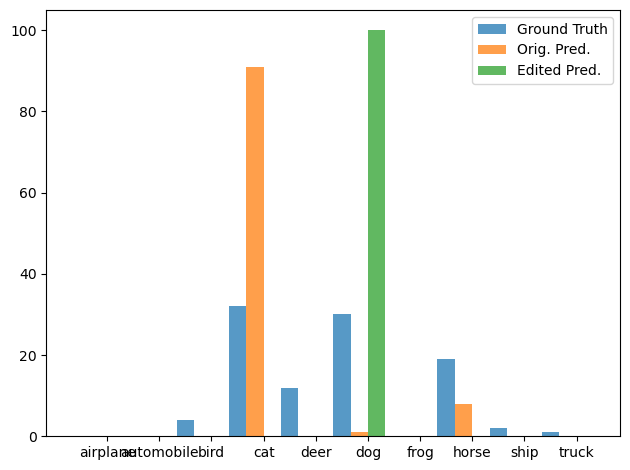

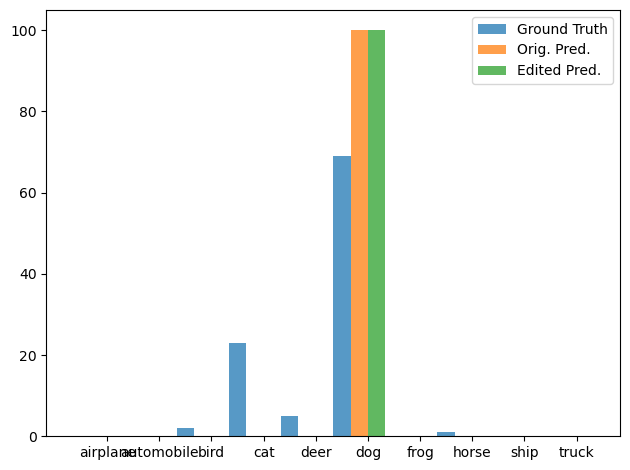

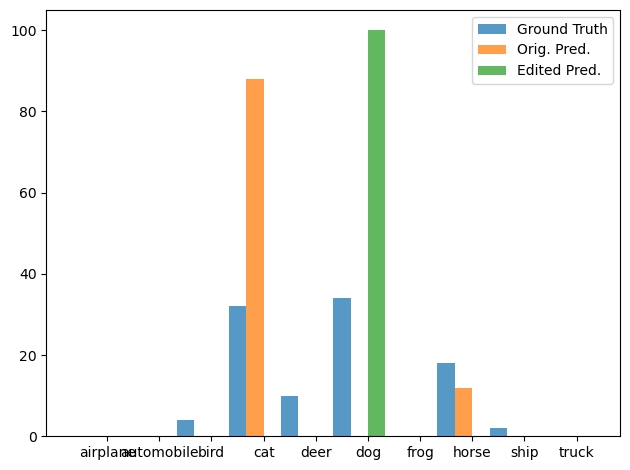

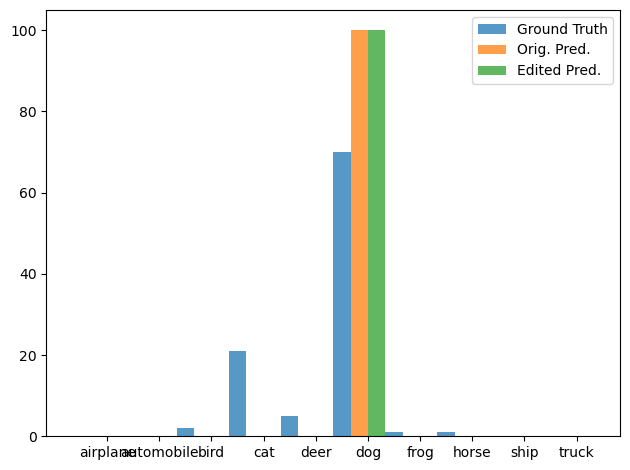

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02084732_5331/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02084732_5331/felzenszwalb_masked_softmax/models
Finished trial 1/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02084732_5331/felzenszwalb_masked_softmax
(0125_140555) Starting Trial 2/27...
Current run_id: 0125_134842/results/dog-train-n02117900_378/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02117900_378/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-image

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 40.39it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:46<00:00, 863.67it/s]

Loss (orig, final): 0.0395793691277504 0.004843185655772686
L2 norm of weight change: 0.19589710235595703
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 25.45it/s]


Post-edit metrics: {'TP': array([6048, 5452, 5076, 3724, 4407, 3328, 5722, 4803, 5078, 4499]), 'TN': array([60541, 61007, 59837, 59997, 59827, 61140, 60855, 62201, 61236,
       61496]), 'FPs': array([2459, 1993, 3163, 3003, 3173, 1860, 2145,  799, 1764, 1504]), 'FNs': array([ 952, 1548, 1924, 3276, 2593, 3672, 1278, 2197, 1922, 2501]), 'accuracy': 0.6876714285714286, 'per_class_accuracy': array([0.95127143, 0.94941429, 0.92732857, 0.9103    , 0.91762857,
       0.92097143, 0.9511    , 0.9572    , 0.94734286, 0.94278571]), 'per_class_accuracy_mean': 0.9375342857142858, 'precision': array([0.71094393, 0.73230356, 0.61609419, 0.55359001, 0.58139842,
       0.64148034, 0.72734206, 0.85737237, 0.74218065, 0.7494586 ]), 'precision_mean': 0.6912164122442939, 'recall': array([0.864     , 0.77885714, 0.72514286, 0.532     , 0.62957143,
       0.47542857, 0.81742857, 0.68614286, 0.72542857, 0.64271429]), 'recall_mean': 0.6876714285714286, 'predicted_class_distribution': array([8507, 7445, 8239,

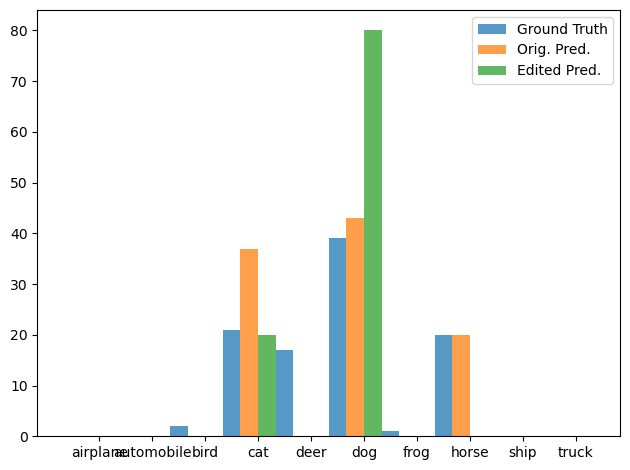

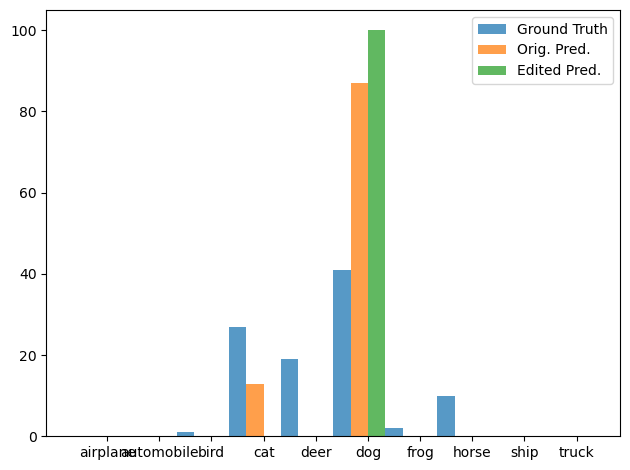

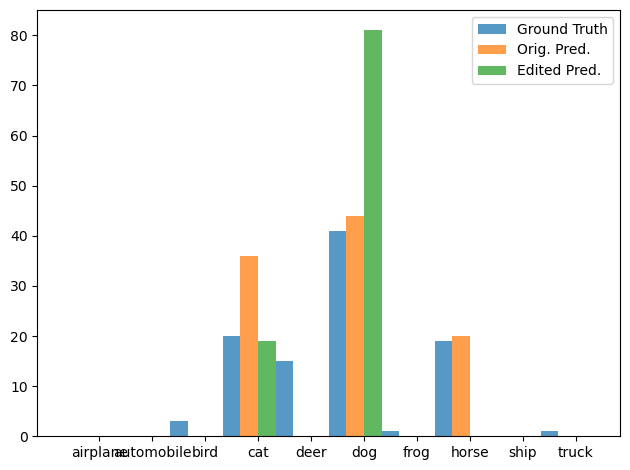

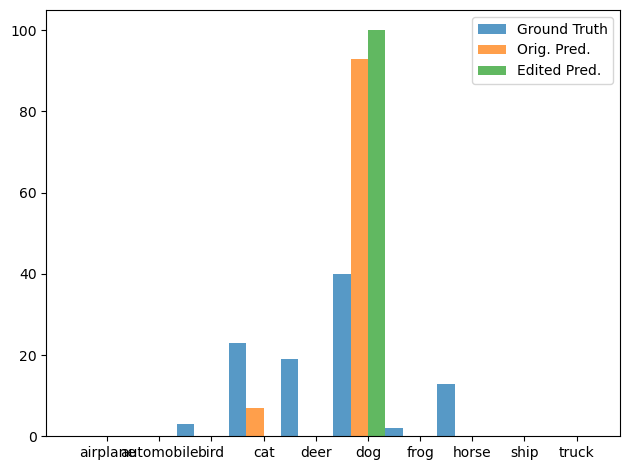

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02117900_378/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02117900_378/felzenszwalb_gaussian_softmax/models
Finished trial 2/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02117900_378/felzenszwalb_gaussian_softmax
(0125_140706) Starting Trial 3/27...
Current run_id: 0125_134842/results/dog-train-n02084861_6547/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02084861_6547/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imag

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 38.15it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0070, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 883.22it/s]

Loss (orig, final): 0.09395645558834076 0.006987063679844141
L2 norm of weight change: 0.41052335500717163
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 21.96it/s]


Post-edit metrics: {'TP': array([5922, 5783, 5056, 1508, 4147, 5012, 5433, 4867, 4953, 3991]), 'TN': array([60998, 60228, 60070, 62687, 60462, 54966, 61662, 62152, 61398,
       62049]), 'FPs': array([2002, 2772, 2930,  313, 2538, 8034, 1338,  848, 1602,  951]), 'FNs': array([1078, 1217, 1944, 5492, 2853, 1988, 1567, 2133, 2047, 3009]), 'accuracy': 0.6667428571428572, 'per_class_accuracy': array([0.956     , 0.94301429, 0.93037143, 0.91707143, 0.92298571,
       0.85682857, 0.9585    , 0.95741429, 0.94787143, 0.94342857]), 'per_class_accuracy_mean': 0.9333485714285713, 'precision': array([0.74734982, 0.67597896, 0.63310794, 0.82811642, 0.62034405,
       0.38417906, 0.80239256, 0.85161855, 0.75560641, 0.80756779]), 'precision_mean': 0.7106261551820683, 'recall': array([0.846     , 0.82614286, 0.72228571, 0.21542857, 0.59242857,
       0.716     , 0.77614286, 0.69528571, 0.70757143, 0.57014286]), 'recall_mean': 0.6667428571428571, 'predicted_class_distribution': array([ 7924,  8555,  79

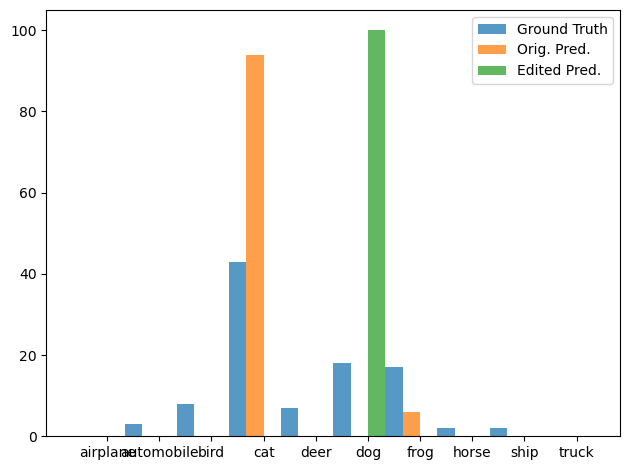

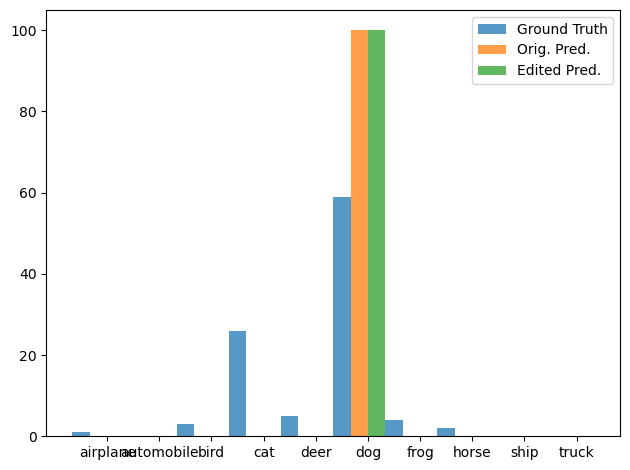

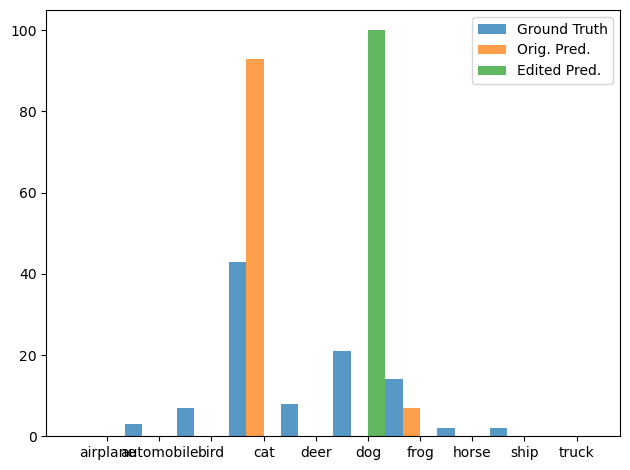

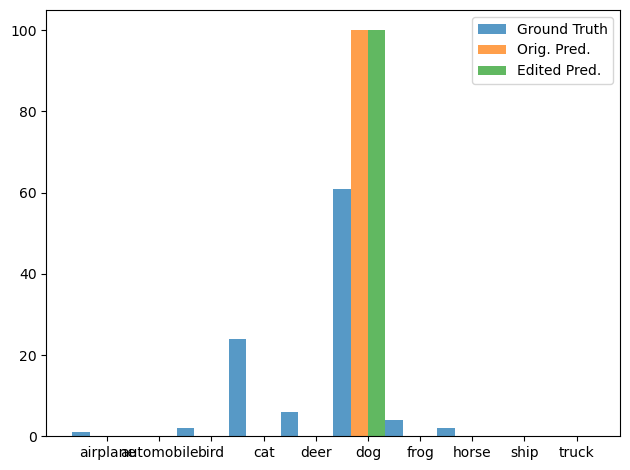

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02084861_6547/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02084861_6547/felzenszwalb_masked_softmax/models
Finished trial 3/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02084861_6547/felzenszwalb_masked_softmax
(0125_140817) Starting Trial 4/27...
Current run_id: 0125_134842/results/dog-train-n02112018_6624/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02112018_6624/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagene

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.40it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0060, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 883.66it/s]

Loss (orig, final): 0.1319400519132614 0.005987030453979969
L2 norm of weight change: 0.49883514642715454
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:20<00:00, 13.09it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([5968, 5794, 5779,    0, 4205, 3873, 5545, 5131, 4805, 4031]), 'TN': array([60765, 60156, 55452, 63000, 60217, 58968, 61177, 61813, 61579,
       62004]), 'FPs': array([2235, 2844, 7548,    0, 2783, 4032, 1823, 1187, 1421,  996]), 'FNs': array([1032, 1206, 1221, 7000, 2795, 3127, 1455, 1869, 2195, 2969]), 'accuracy': 0.6447285714285714, 'per_class_accuracy': array([0.95332857, 0.94214286, 0.87472857, 0.9       , 0.92031429,
       0.89772857, 0.95317143, 0.95634286, 0.94834286, 0.94335714]), 'per_class_accuracy_mean': 0.9289457142857144, 'precision': array([0.72753871, 0.67075712, 0.43363097, 0.        , 0.60174585,
       0.48994307, 0.75257872, 0.81212409, 0.77176357, 0.8018699 ]), 'precision_mean': 0.6061952007129825, 'recall': array([0.85257143, 0.82771429, 0.82557143, 0.        , 0.60071429,
       0.55328571, 0.79214286, 0.733     , 0.68642857, 0.57585714]), 'recall_mean': 0.6447285714285714, 'predicted_class_distribution': array([ 8203,  8638, 133

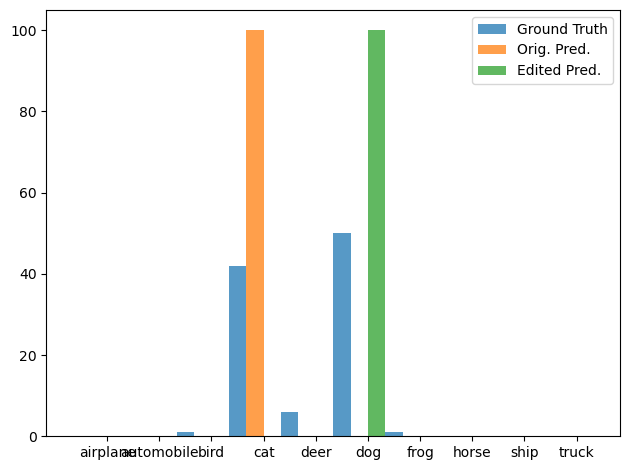

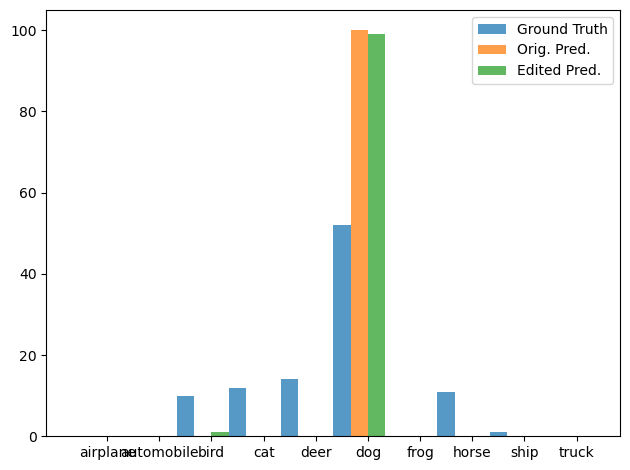

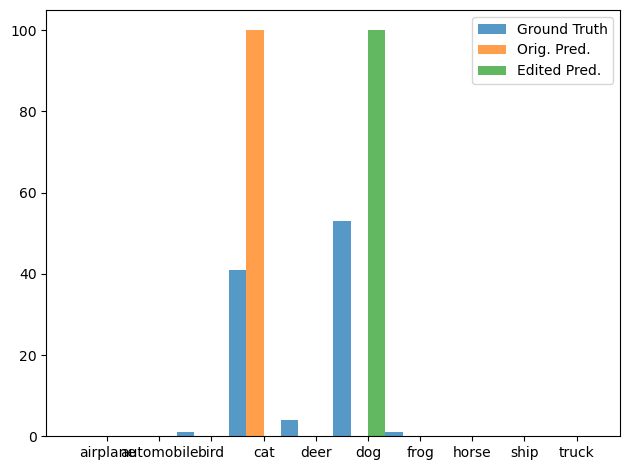

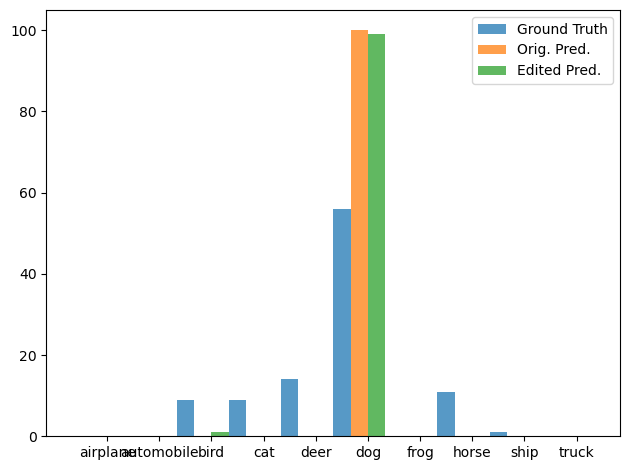

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02112018_6624/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02112018_6624/felzenszwalb_masked_softmax/models
Finished trial 4/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02112018_6624/felzenszwalb_masked_softmax
(0125_140944) Starting Trial 5/27...
Current run_id: 0125_134842/results/dog-train-n02084861_13239/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02084861_13239/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-image

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:10<00:00, 26.34it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0507, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:44<00:00, 891.27it/s]

Loss (orig, final): 0.17471620440483093 0.05068332701921463
L2 norm of weight change: 0.4313165247440338
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:25<00:00, 10.85it/s]


Post-edit metrics: {'TP': array([6045, 5607, 5481, 2083, 4443, 3326, 5710, 5394, 4725, 4418]), 'TN': array([60521, 60650, 58058, 62502, 59407, 61255, 60741, 60757, 61751,
       61590]), 'FPs': array([2479, 2350, 4942,  498, 3593, 1745, 2259, 2243, 1249, 1410]), 'FNs': array([ 955, 1393, 1519, 4917, 2557, 3674, 1290, 1606, 2275, 2582]), 'accuracy': 0.6747428571428571, 'per_class_accuracy': array([0.95094286, 0.94652857, 0.9077    , 0.92264286, 0.91214286,
       0.92258571, 0.9493    , 0.94501429, 0.94965714, 0.94297143]), 'per_class_accuracy_mean': 0.9349485714285715, 'precision': array([0.7091741 , 0.70466256, 0.52585628, 0.80705153, 0.55288701,
       0.65588641, 0.71652654, 0.70629828, 0.79092735, 0.75806452]), 'precision_mean': 0.692733458212764, 'recall': array([0.86357143, 0.801     , 0.783     , 0.29757143, 0.63471429,
       0.47514286, 0.81571429, 0.77057143, 0.675     , 0.63114286]), 'recall_mean': 0.6747428571428571, 'predicted_class_distribution': array([ 8524,  7957, 1042

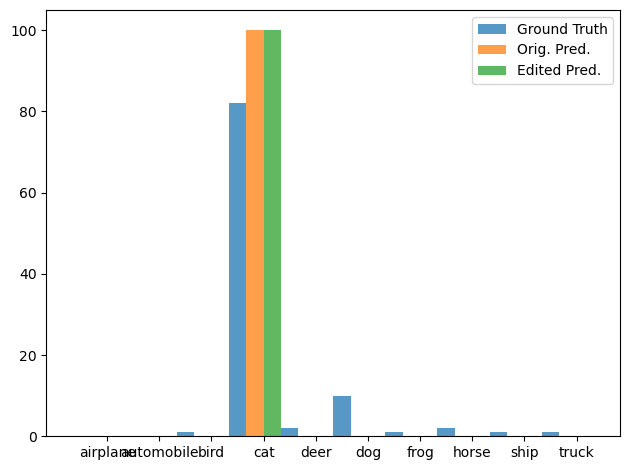

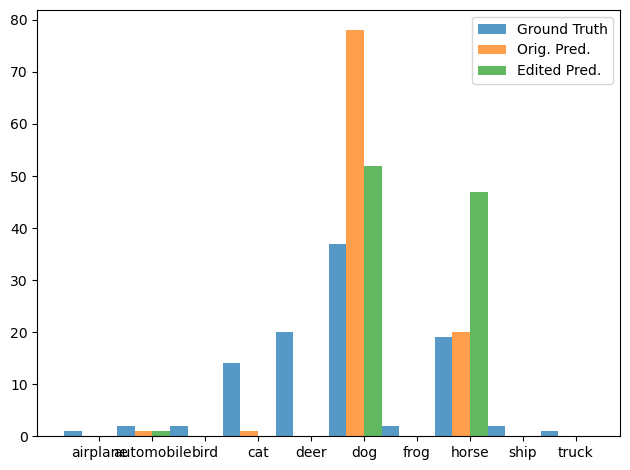

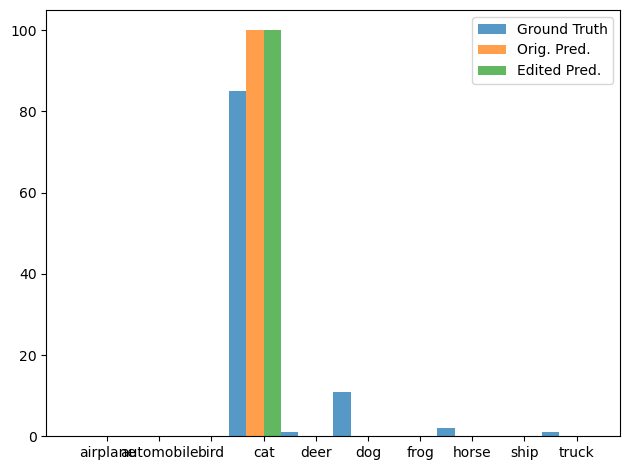

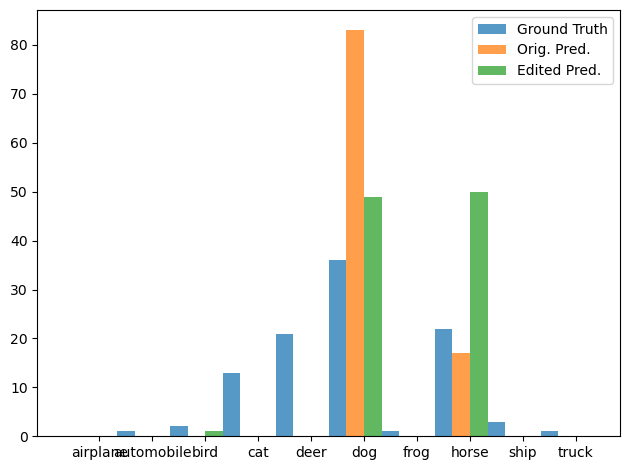

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02084861_13239/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02084861_13239/felzenszwalb_masked_softmax/models
Finished trial 5/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02084861_13239/felzenszwalb_masked_softmax
(0125_141113) Starting Trial 6/27...
Current run_id: 0125_134842/results/dog-train-n02104523_6545/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02104523_6545/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imag

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 22.40it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0091, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 879.32it/s]

Loss (orig, final): 0.13661128282546997 0.009077388793230057
L2 norm of weight change: 0.4041593670845032
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [14:19<00:00,  3.14s/it]


Post-edit metrics: {'TP': array([6002, 5704, 5762,    3, 4131, 4035, 5468, 5150, 4794, 4132]), 'TN': array([60557, 60423, 56105, 62990, 60355, 58114, 61346, 61757, 61612,
       61922]), 'FPs': array([2443, 2577, 6895,   10, 2645, 4886, 1654, 1243, 1388, 1078]), 'FNs': array([ 998, 1296, 1238, 6997, 2869, 2965, 1532, 1850, 2206, 2868]), 'accuracy': 0.6454428571428571, 'per_class_accuracy': array([0.95084286, 0.94467143, 0.88381429, 0.8999    , 0.92122857,
       0.88784286, 0.95448571, 0.95581429, 0.94865714, 0.94362857]), 'per_class_accuracy_mean': 0.9290885714285715, 'precision': array([0.7107164 , 0.6888057 , 0.45524216, 0.23076923, 0.60965171,
       0.45230355, 0.76776186, 0.80556859, 0.77547719, 0.79309021]), 'precision_mean': 0.6289386612898393, 'recall': array([8.57428571e-01, 8.14857143e-01, 8.23142857e-01, 4.28571429e-04,
       5.90142857e-01, 5.76428571e-01, 7.81142857e-01, 7.35714286e-01,
       6.84857143e-01, 5.90285714e-01]), 'recall_mean': 0.6454428571428572, 'predicte

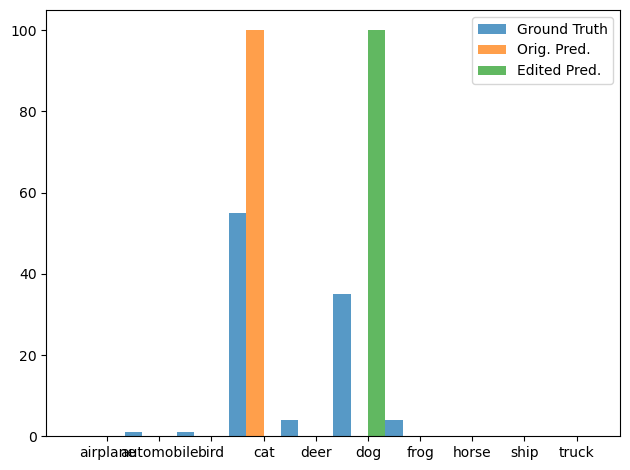

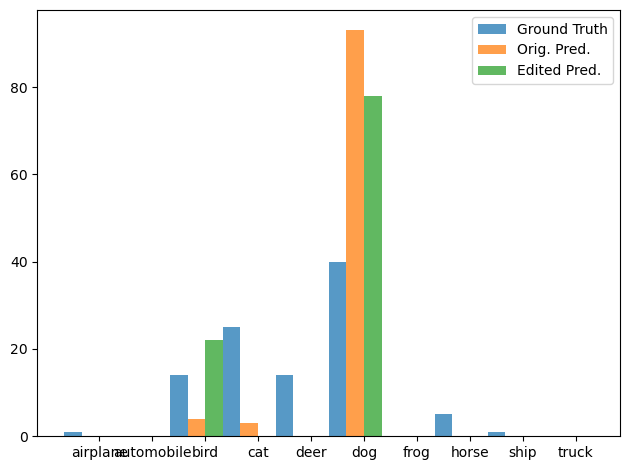

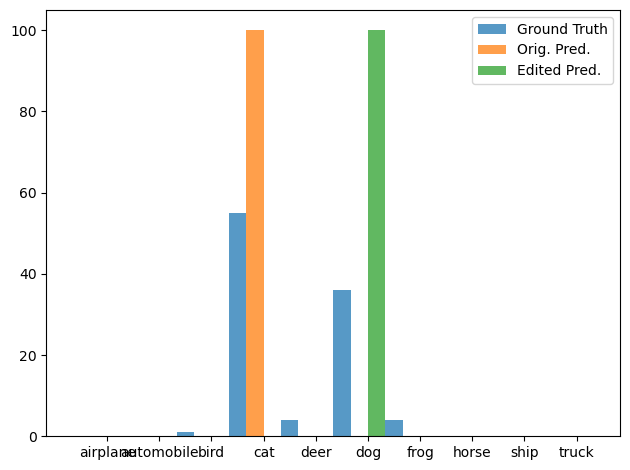

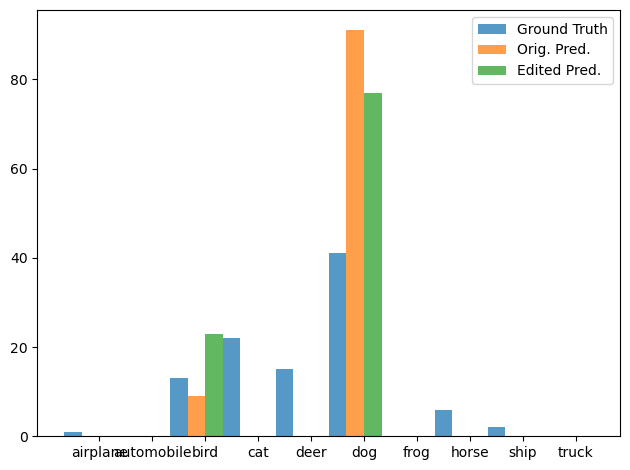

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02104523_6545/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02104523_6545/felzenszwalb_masked_softmax/models
Finished trial 6/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02104523_6545/felzenszwalb_masked_softmax
(0125_142640) Starting Trial 7/27...
Current run_id: 0125_134842/results/dog-train-n02112018_292/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02112018_292/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:23<00:00, 11.42it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0073, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 884.56it/s]

Loss (orig, final): 0.08865172415971756 0.007340843323618174
L2 norm of weight change: 0.2972802221775055
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:22<00:00, 12.42it/s]


Post-edit metrics: {'TP': array([6106, 5561, 5462, 2900, 4279, 3308, 5559, 5412, 4696, 4492]), 'TN': array([60284, 60751, 58282, 61640, 59996, 61318, 61217, 61017, 61782,
       61488]), 'FPs': array([2716, 2249, 4718, 1360, 3004, 1682, 1783, 1983, 1218, 1512]), 'FNs': array([ 894, 1439, 1538, 4100, 2721, 3692, 1441, 1588, 2304, 2508]), 'accuracy': 0.6825, 'per_class_accuracy': array([0.94842857, 0.94731429, 0.91062857, 0.922     , 0.91821429,
       0.92322857, 0.95394286, 0.94898571, 0.94968571, 0.94257143]), 'per_class_accuracy_mean': 0.9364999999999999, 'precision': array([0.6921333 , 0.71203585, 0.53654224, 0.68075117, 0.58753261,
       0.66292585, 0.75715064, 0.73184584, 0.79404802, 0.74816789]), 'precision_mean': 0.6903133421520149, 'recall': array([0.87228571, 0.79442857, 0.78028571, 0.41428571, 0.61128571,
       0.47257143, 0.79414286, 0.77314286, 0.67085714, 0.64171429]), 'recall_mean': 0.6825, 'predicted_class_distribution': array([ 8822,  7810, 10180,  4260,  7283,  4990,

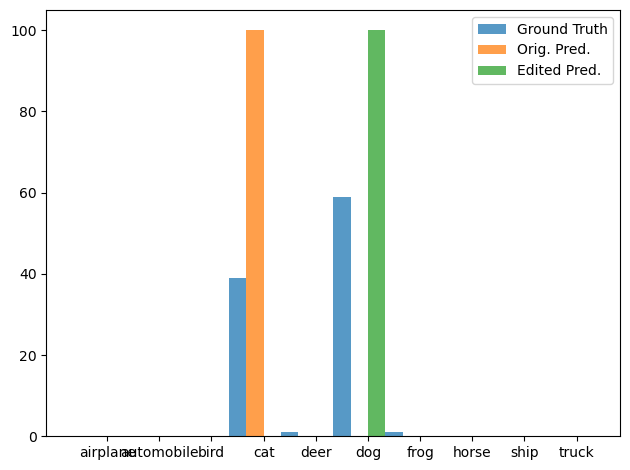

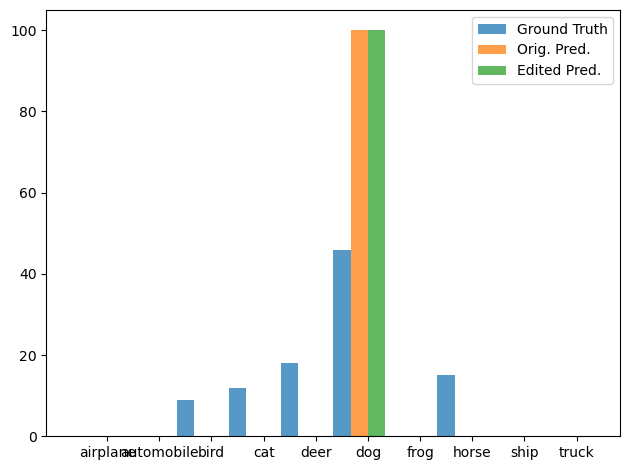

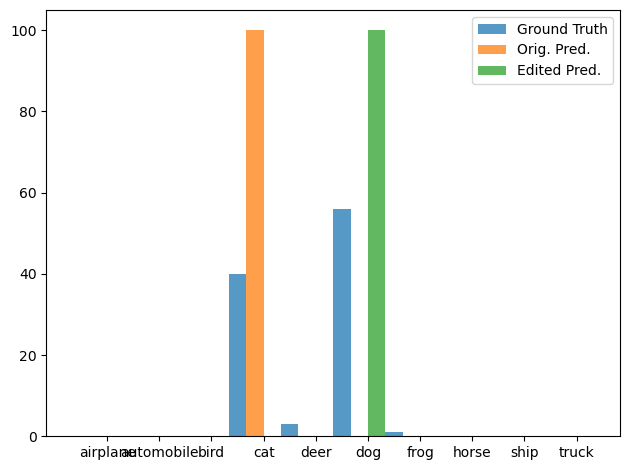

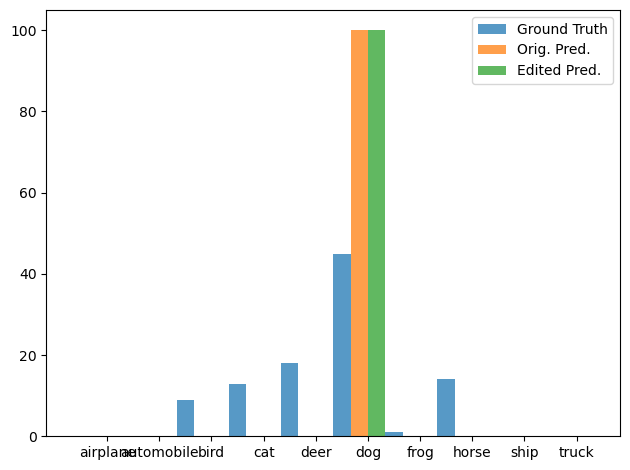

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02112018_292/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02112018_292/felzenszwalb_masked_softmax/models
Finished trial 7/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02112018_292/felzenszwalb_masked_softmax
(0125_142819) Starting Trial 8/27...
Current run_id: 0125_134842/results/dog-train-n02117135_2677/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02117135_2677/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imagenet/t

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.67it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0838, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 874.63it/s]

Loss (orig, final): 0.195265531539917 0.0838102176785469
L2 norm of weight change: 0.39407938718795776
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:18<00:00, 15.16it/s]


Post-edit metrics: {'TP': array([6149, 5431, 5363, 4242, 2880, 3273, 5600, 5222, 4736, 4720]), 'TN': array([60079, 60983, 58736, 58776, 62284, 61212, 61175, 61607, 61723,
       61041]), 'FPs': array([2921, 2017, 4264, 4224,  716, 1788, 1825, 1393, 1277, 1959]), 'FNs': array([ 851, 1569, 1637, 2758, 4120, 3727, 1400, 1778, 2264, 2280]), 'accuracy': 0.6802285714285714, 'per_class_accuracy': array([0.94611429, 0.94877143, 0.9157    , 0.90025714, 0.93091429,
       0.92121429, 0.95392857, 0.9547    , 0.94941429, 0.93944286]), 'per_class_accuracy_mean': 0.9360457142857144, 'precision': array([0.67794928, 0.72918904, 0.55707905, 0.50106308, 0.80088988,
       0.64671014, 0.75420875, 0.78941799, 0.78762681, 0.70669262]), 'precision_mean': 0.6950826636574675, 'recall': array([0.87842857, 0.77585714, 0.76614286, 0.606     , 0.41142857,
       0.46757143, 0.8       , 0.746     , 0.67657143, 0.67428571]), 'recall_mean': 0.6802285714285714, 'predicted_class_distribution': array([9070, 7448, 9627,

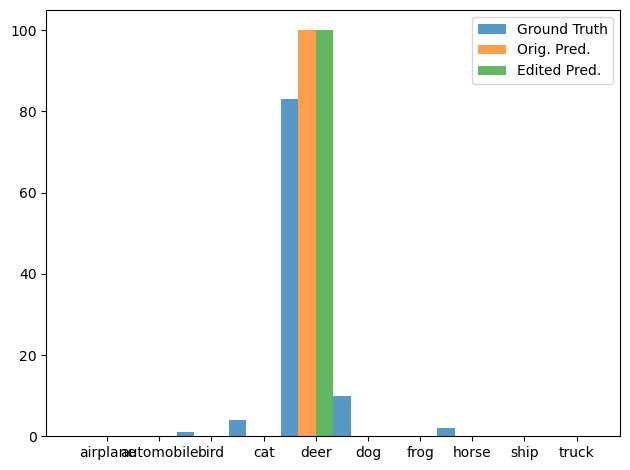

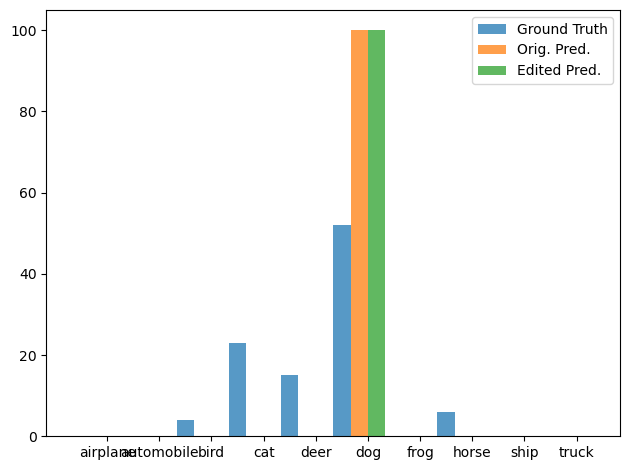

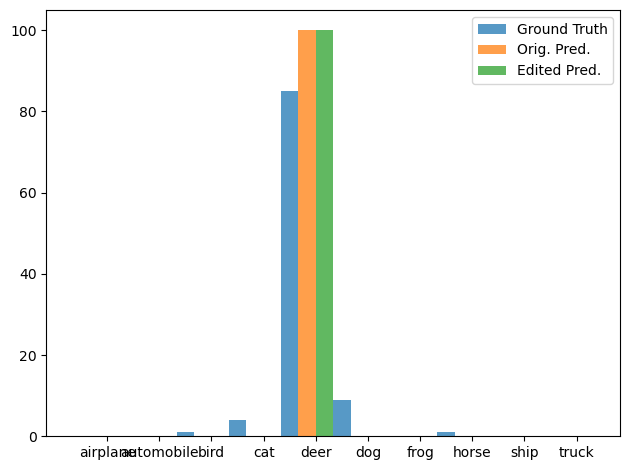

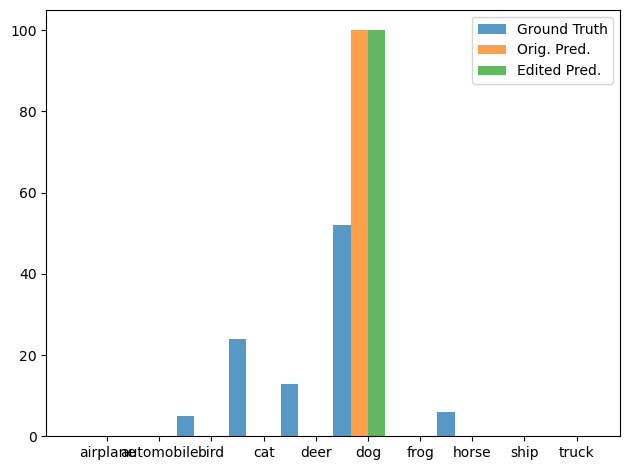

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02117135_2677/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02117135_2677/felzenszwalb_masked_softmax/models
Finished trial 8/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02117135_2677/felzenszwalb_masked_softmax
(0125_142944) Starting Trial 9/27...
Current run_id: 0125_134842/results/dog-train-n02114367_15682/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114367_15682/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-image

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 29.87it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0330, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 876.87it/s]

Loss (orig, final): 0.14938005805015564 0.03299146145582199
L2 norm of weight change: 0.33651965856552124
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:16<00:00, 16.81it/s]


Post-edit metrics: {'TP': array([6141, 5375, 5098, 4720, 2713, 3178, 5557, 5178, 4752, 4787]), 'TN': array([60144, 61101, 59810, 56811, 62421, 61403, 61343, 61709, 61742,
       61015]), 'FPs': array([2856, 1899, 3190, 6189,  579, 1597, 1657, 1291, 1258, 1985]), 'FNs': array([ 859, 1625, 1902, 2280, 4287, 3822, 1443, 1822, 2248, 2213]), 'accuracy': 0.6785571428571429, 'per_class_accuracy': array([0.94692857, 0.94965714, 0.92725714, 0.87901429, 0.93048571,
       0.92258571, 0.95571429, 0.95552857, 0.94991429, 0.94002857]), 'per_class_accuracy_mean': 0.9357114285714287, 'precision': array([0.68256085, 0.73893319, 0.61510618, 0.43267027, 0.82411908,
       0.66554974, 0.77030773, 0.80043283, 0.7906822 , 0.70688128]), 'precision_mean': 0.7027243345592369, 'recall': array([0.87728571, 0.76785714, 0.72828571, 0.67428571, 0.38757143,
       0.454     , 0.79385714, 0.73971429, 0.67885714, 0.68385714]), 'recall_mean': 0.6785571428571429, 'predicted_class_distribution': array([ 8997,  7274,  82

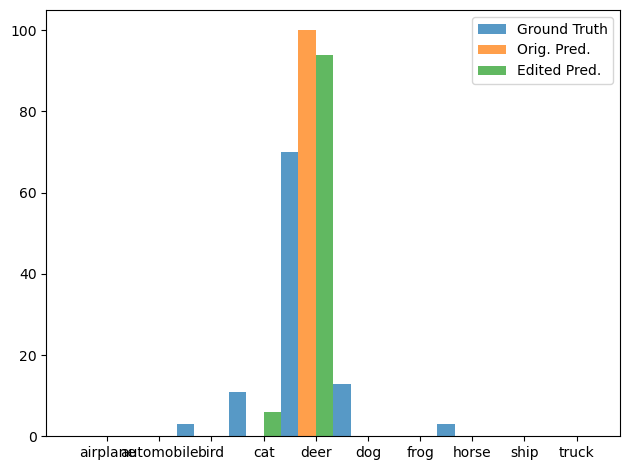

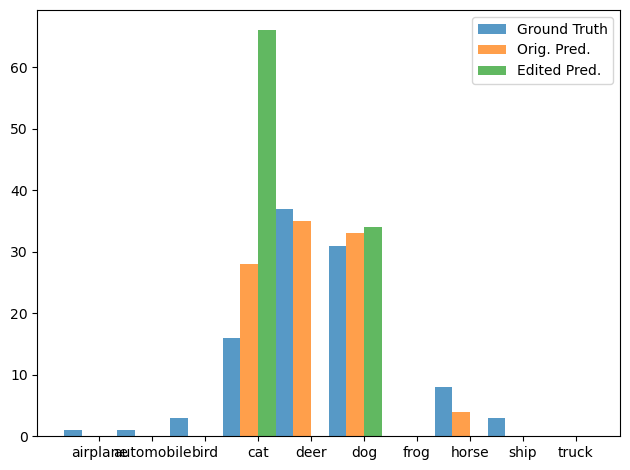

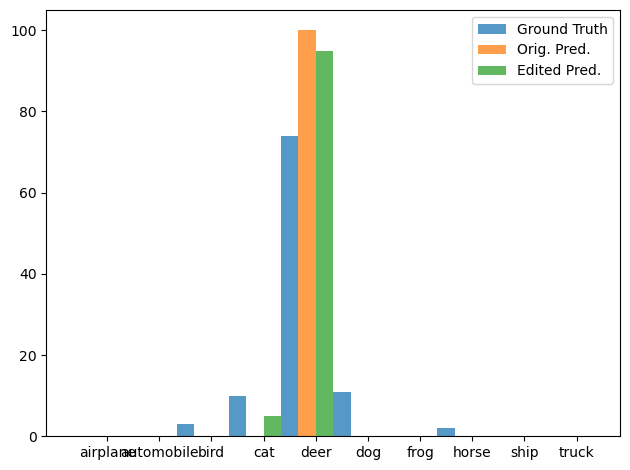

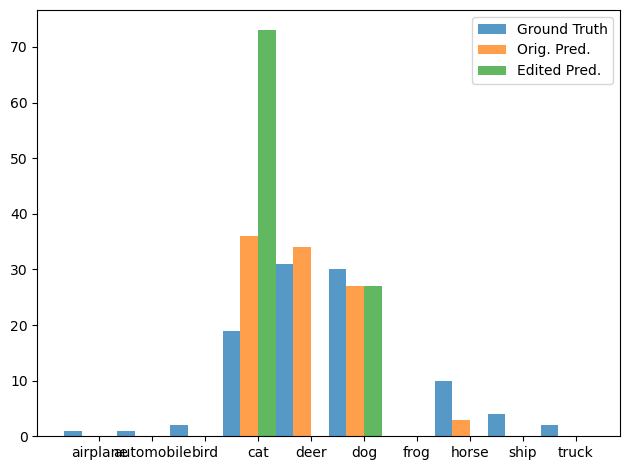

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114367_15682/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114367_15682/felzenszwalb_masked_softmax/models
Finished trial 9/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114367_15682/felzenszwalb_masked_softmax
(0125_143102) Starting Trial 10/27...
Current run_id: 0125_134842/results/dog-train-n02114548_7558/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114548_7558/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-ima

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.71it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 882.99it/s]

Loss (orig, final): 0.018461598083376884 0.0035242903977632523
L2 norm of weight change: 0.1392642855644226
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 18.38it/s]


Post-edit metrics: {'TP': array([6116, 5454, 5124, 3763, 4285, 3189, 5666, 5157, 4870, 4624]), 'TN': array([60234, 60985, 59734, 60096, 60117, 61434, 61071, 61701, 61600,
       61276]), 'FPs': array([2766, 2015, 3266, 2904, 2883, 1566, 1929, 1299, 1400, 1724]), 'FNs': array([ 884, 1546, 1876, 3237, 2715, 3811, 1334, 1843, 2130, 2376]), 'accuracy': 0.6892571428571429, 'per_class_accuracy': array([0.94785714, 0.94912857, 0.92654286, 0.91227143, 0.92002857,
       0.92318571, 0.95338571, 0.95511429, 0.94957143, 0.94142857]), 'per_class_accuracy_mean': 0.9378514285714287, 'precision': array([0.68858365, 0.73021824, 0.61072706, 0.56442178, 0.59779576,
       0.67066246, 0.74601712, 0.79879182, 0.77671451, 0.7284184 ]), 'precision_mean': 0.691235079326784, 'recall': array([0.87371429, 0.77914286, 0.732     , 0.53757143, 0.61214286,
       0.45557143, 0.80942857, 0.73671429, 0.69571429, 0.66057143]), 'recall_mean': 0.6892571428571429, 'predicted_class_distribution': array([8882, 7469, 8390, 

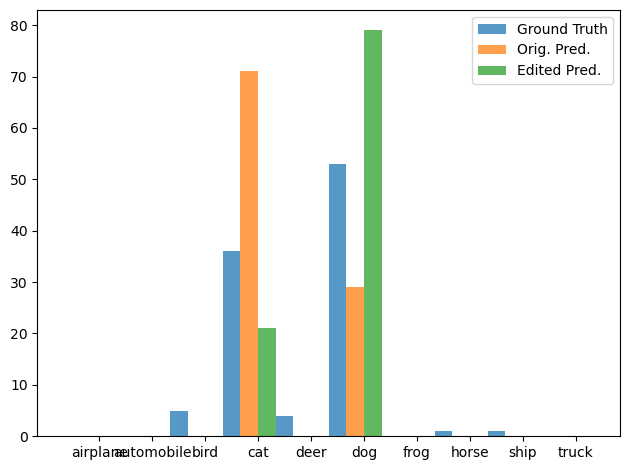

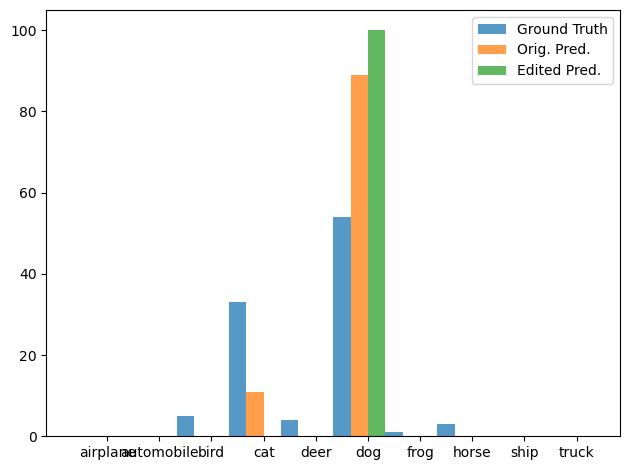

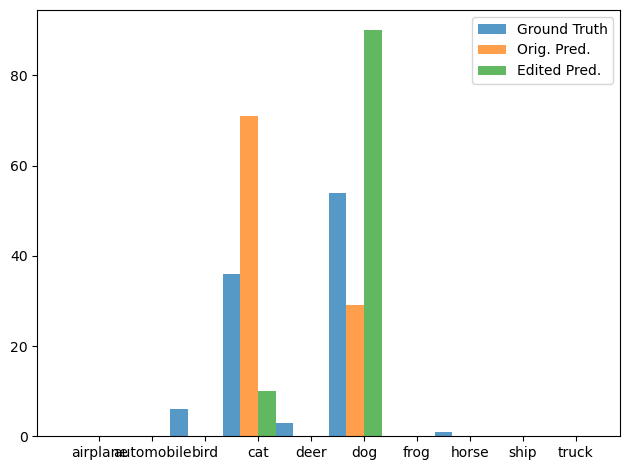

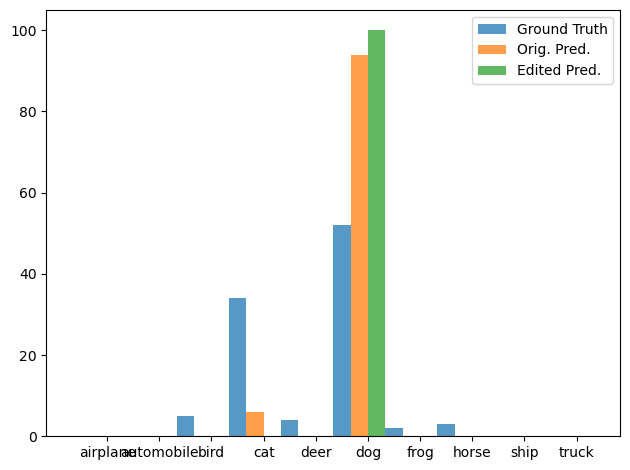

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114548_7558/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114548_7558/felzenszwalb_masked_softmax/models
Finished trial 10/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114548_7558/felzenszwalb_masked_softmax
(0125_143223) Starting Trial 11/27...
Current run_id: 0125_134842/results/dog-train-n02114548_7558/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114548_7558/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-i

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:17<00:00, 16.11it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 885.86it/s]

Loss (orig, final): 0.07981383800506592 0.005118514411151409
L2 norm of weight change: 0.3279465436935425
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:16<00:00, 16.19it/s]


Post-edit metrics: {'TP': array([6009, 5706, 5255, 2564, 4325, 4004, 5705, 5122, 4912, 4280]), 'TN': array([60684, 60373, 59296, 61940, 59955, 59711, 60934, 61813, 61459,
       61717]), 'FPs': array([2316, 2627, 3704, 1060, 3045, 3289, 2066, 1187, 1541, 1283]), 'FNs': array([ 991, 1294, 1745, 4436, 2675, 2996, 1295, 1878, 2088, 2720]), 'accuracy': 0.6840285714285714, 'per_class_accuracy': array([0.95275714, 0.94398571, 0.92215714, 0.92148571, 0.91828571,
       0.91021429, 0.95198571, 0.95621429, 0.94815714, 0.94281429]), 'per_class_accuracy_mean': 0.9368057142857144, 'precision': array([0.7218018 , 0.68474739, 0.586561  , 0.70750552, 0.58683853,
       0.54901961, 0.73413975, 0.81185608, 0.76119634, 0.76936905]), 'precision_mean': 0.6913035070252767, 'recall': array([0.85842857, 0.81514286, 0.75071429, 0.36628571, 0.61785714,
       0.572     , 0.815     , 0.73171429, 0.70171429, 0.61142857]), 'recall_mean': 0.6840285714285714, 'predicted_class_distribution': array([8325, 8333, 8959,

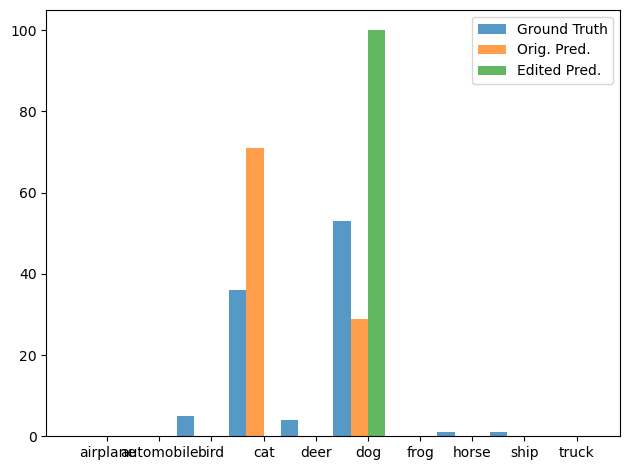

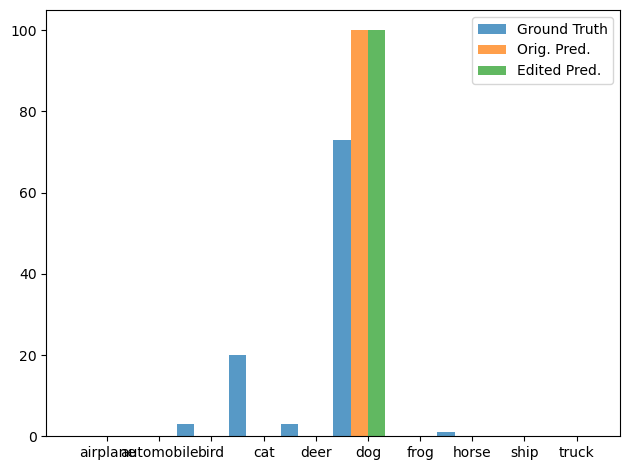

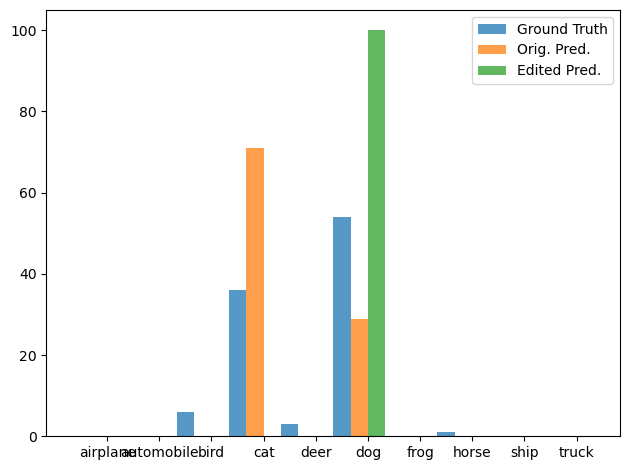

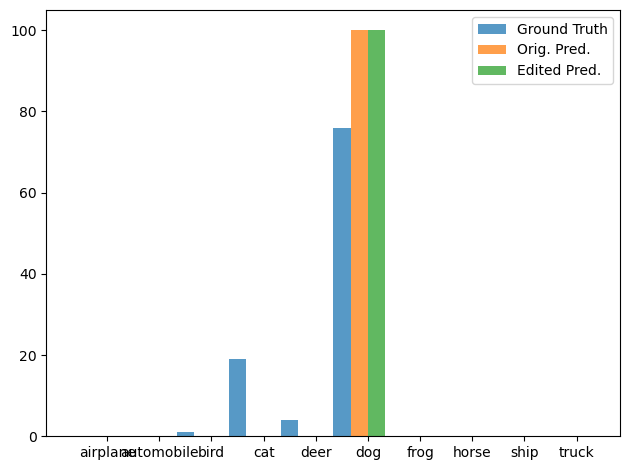

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114548_7558/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114548_7558/felzenszwalb_gaussian_softmax/models
Finished trial 11/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114548_7558/felzenszwalb_gaussian_softmax
(0125_143353) Starting Trial 12/27...
Current run_id: 0125_134842/results/dog-train-n02112826_4815/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02112826_4815/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 17.61it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0119, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 874.52it/s]

Loss (orig, final): 0.1469564139842987 0.011938031762838364
L2 norm of weight change: 0.4469568431377411
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:12<00:00, 22.44it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([5979, 5761, 5422,    0, 4239, 4394, 5498, 5290, 4865, 4179]), 'TN': array([60774, 60200, 58549, 63000, 60155, 56681, 61426, 61415, 61566,
       61861]), 'FPs': array([2226, 2800, 4451,    0, 2845, 6319, 1574, 1585, 1434, 1139]), 'FNs': array([1021, 1239, 1578, 7000, 2761, 2606, 1502, 1710, 2135, 2821]), 'accuracy': 0.6518142857142857, 'per_class_accuracy': array([0.95361429, 0.9423    , 0.91387143, 0.9       , 0.91991429,
       0.8725    , 0.95605714, 0.95292857, 0.94901429, 0.94342857]), 'per_class_accuracy_mean': 0.9303628571428572, 'precision': array([0.72870201, 0.6729354 , 0.54917452, 0.        , 0.59839074,
       0.41015589, 0.77743213, 0.76945455, 0.77234482, 0.78582174]), 'precision_mean': 0.6064411783421338, 'recall': array([0.85414286, 0.823     , 0.77457143, 0.        , 0.60557143,
       0.62771429, 0.78542857, 0.75571429, 0.695     , 0.597     ]), 'recall_mean': 0.6518142857142857, 'predicted_class_distribution': array([ 8205,  8561,  98

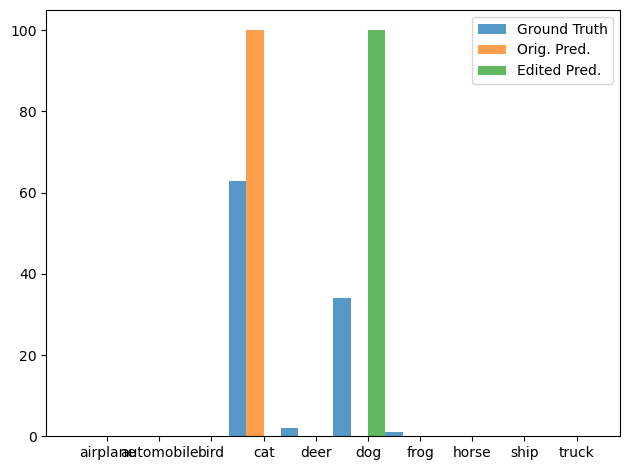

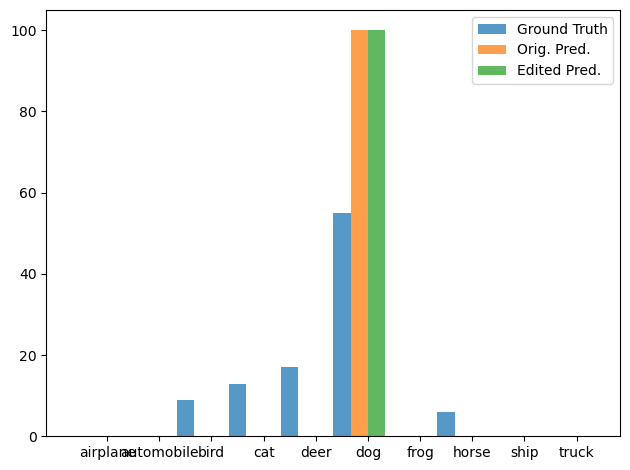

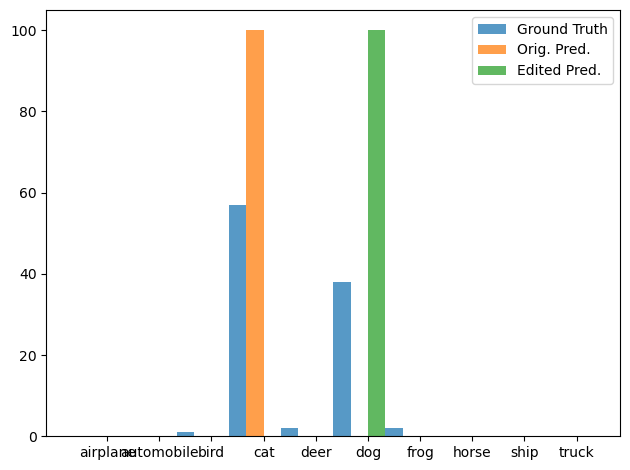

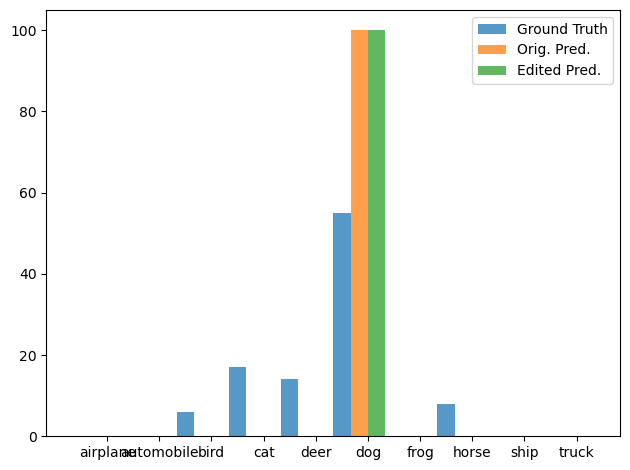

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02112826_4815/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02112826_4815/felzenszwalb_masked_softmax/models
Finished trial 12/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02112826_4815/felzenszwalb_masked_softmax
(0125_143513) Starting Trial 13/27...
Current run_id: 0125_134842/results/dog-train-n02114100_6249/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114100_6249/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-image

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 30.42it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0427, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 875.22it/s]

Loss (orig, final): 0.18132077157497406 0.04271136224269867
L2 norm of weight change: 0.47379377484321594
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:26<00:00, 10.48it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6139, 5254, 5532, 4351, 4005, 3165,    0, 5209, 4933, 4612]), 'TN': array([59985, 61347, 57582, 54771, 60668, 61330, 63000, 61616, 61476,
       61425]), 'FPs': array([3015, 1653, 5418, 8229, 2332, 1670,    0, 1384, 1524, 1575]), 'FNs': array([ 861, 1746, 1468, 2649, 2995, 3835, 7000, 1791, 2067, 2388]), 'accuracy': 0.6171428571428571, 'per_class_accuracy': array([0.94462857, 0.95144286, 0.90162857, 0.8446    , 0.9239    ,
       0.92135714, 0.9       , 0.95464286, 0.9487    , 0.94338571]), 'per_class_accuracy_mean': 0.9234285714285715, 'precision': array([0.67063579, 0.76067757, 0.50520548, 0.34586645, 0.63200252,
       0.65460186, 0.        , 0.79008039, 0.76397708, 0.74543397]), 'precision_mean': 0.5868481123425283, 'recall': array([0.877     , 0.75057143, 0.79028571, 0.62157143, 0.57214286,
       0.45214286, 0.        , 0.74414286, 0.70471429, 0.65885714]), 'recall_mean': 0.6171428571428572, 'predicted_class_distribution': array([ 9154,  6907, 109

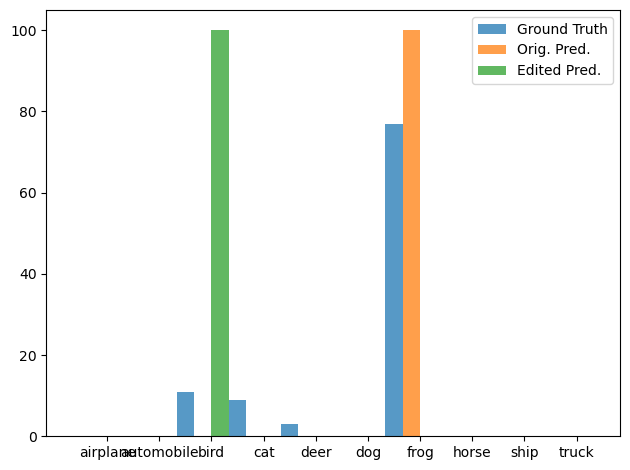

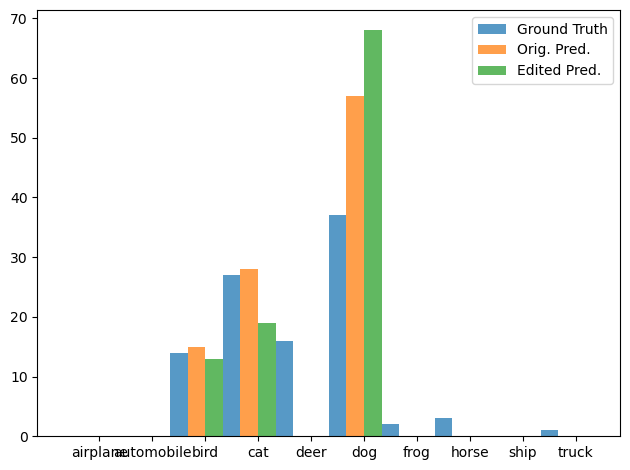

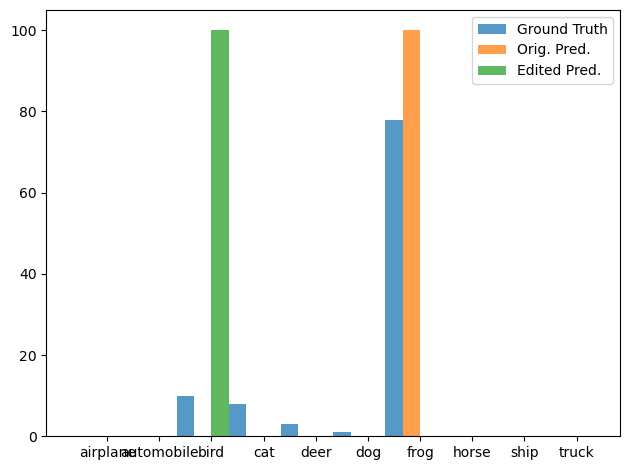

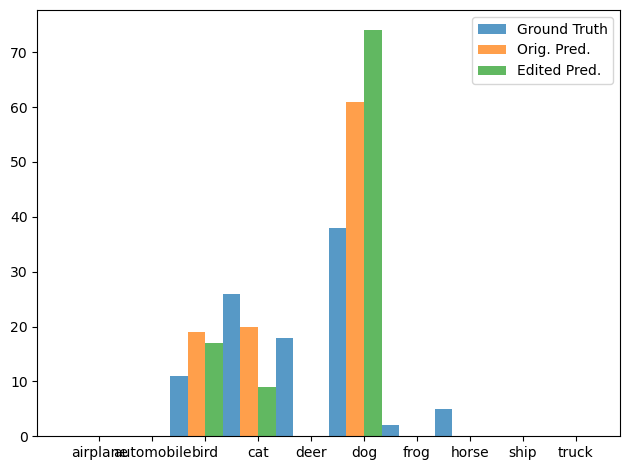

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114100_6249/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114100_6249/felzenszwalb_masked_softmax/models
Finished trial 13/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114100_6249/felzenszwalb_masked_softmax
(0125_143647) Starting Trial 14/27...
Current run_id: 0125_134842/results/dog-train-n02114367_18628/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114367_18628/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-ima

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:18<00:00, 14.69it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 874.94it/s]

Loss (orig, final): 0.04293283075094223 0.004339578561484814
L2 norm of weight change: 0.14798904955387115
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:15<00:00, 17.14it/s]


Post-edit metrics: {'TP': array([6142, 5485, 5414, 3522, 4087, 3132, 5607, 5291, 4692, 4578]), 'TN': array([60110, 60922, 58577, 60529, 60509, 61561, 61157, 61428, 61778,
       61379]), 'FPs': array([2890, 2078, 4423, 2471, 2491, 1439, 1843, 1572, 1222, 1621]), 'FNs': array([ 858, 1515, 1586, 3478, 2913, 3868, 1393, 1709, 2308, 2422]), 'accuracy': 0.685, 'per_class_accuracy': array([0.94645714, 0.94867143, 0.91415714, 0.91501429, 0.9228    ,
       0.92418571, 0.95377143, 0.95312857, 0.94957143, 0.94224286]), 'per_class_accuracy_mean': 0.9369999999999999, 'precision': array([0.68002657, 0.72524131, 0.55037105, 0.58768563, 0.62131347,
       0.68518924, 0.75261745, 0.77094565, 0.79337166, 0.73850621]), 'precision_mean': 0.690526823690109, 'recall': array([0.87742857, 0.78357143, 0.77342857, 0.50314286, 0.58385714,
       0.44742857, 0.801     , 0.75585714, 0.67028571, 0.654     ]), 'recall_mean': 0.685, 'predicted_class_distribution': array([9032, 7563, 9837, 5993, 6578, 4571, 7450, 68

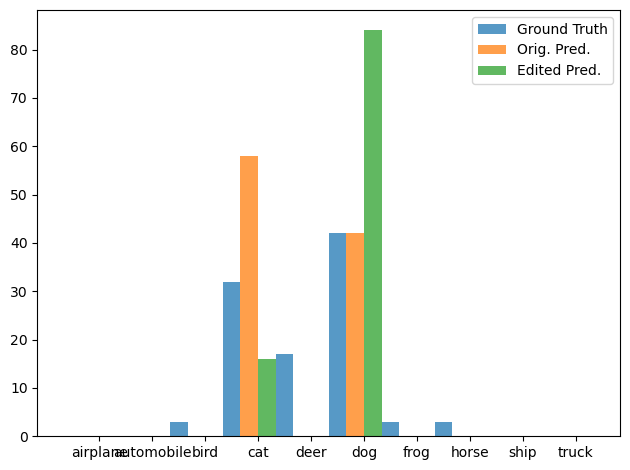

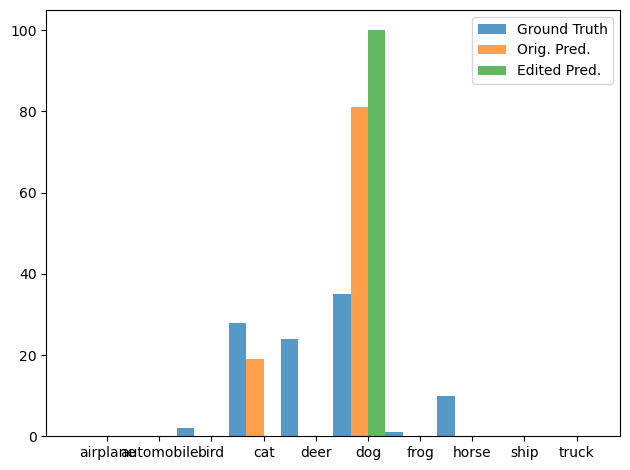

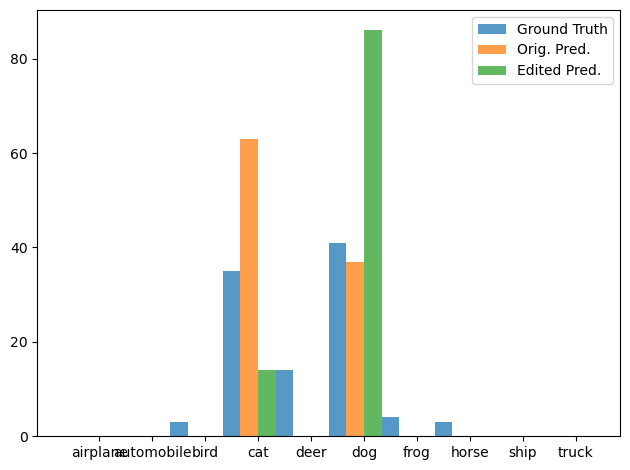

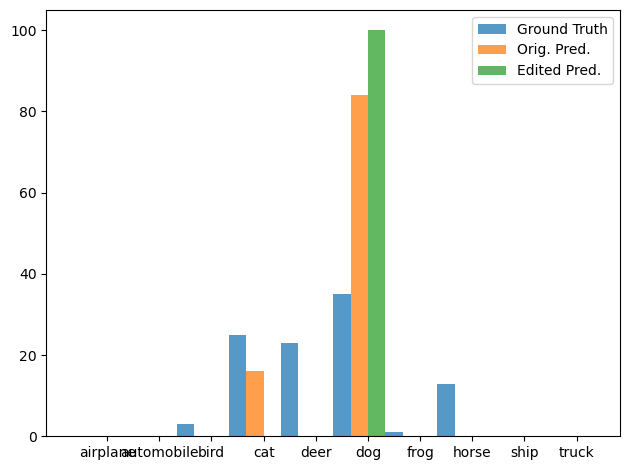

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114367_18628/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114367_18628/felzenszwalb_masked_softmax/models
Finished trial 14/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114367_18628/felzenszwalb_masked_softmax
(0125_143815) Starting Trial 15/27...
Current run_id: 0125_134842/results/dog-train-n02114367_18628/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114367_18628/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.92it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 875.44it/s]

Loss (orig, final): 0.030903004109859467 0.0035612965002655983
L2 norm of weight change: 0.1685875505208969
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [01:18<00:00,  3.48it/s]


Post-edit metrics: {'TP': array([6110, 5415, 5062, 3567, 4587, 3048, 5688, 5080, 4921, 4611]), 'TN': array([60279, 61062, 59848, 60428, 59257, 61642, 60978, 61766, 61511,
       61318]), 'FPs': array([2721, 1938, 3152, 2572, 3743, 1358, 2022, 1234, 1489, 1682]), 'FNs': array([ 890, 1585, 1938, 3433, 2413, 3952, 1312, 1920, 2079, 2389]), 'accuracy': 0.6869857142857143, 'per_class_accuracy': array([0.94841429, 0.94967143, 0.92728571, 0.91421429, 0.91205714,
       0.92414286, 0.95237143, 0.95494286, 0.94902857, 0.94184286]), 'per_class_accuracy_mean': 0.9373971428571428, 'precision': array([0.69188087, 0.73643411, 0.61626491, 0.58103926, 0.55066026,
       0.69178393, 0.73774319, 0.80456129, 0.76770671, 0.73271889]), 'precision_mean': 0.6910793433904555, 'recall': array([0.87285714, 0.77357143, 0.72314286, 0.50957143, 0.65528571,
       0.43542857, 0.81257143, 0.72571429, 0.703     , 0.65871429]), 'recall_mean': 0.6869857142857143, 'predicted_class_distribution': array([8831, 7353, 8214,

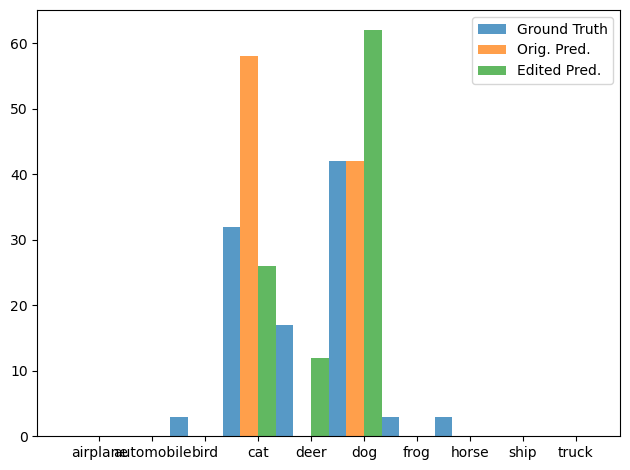

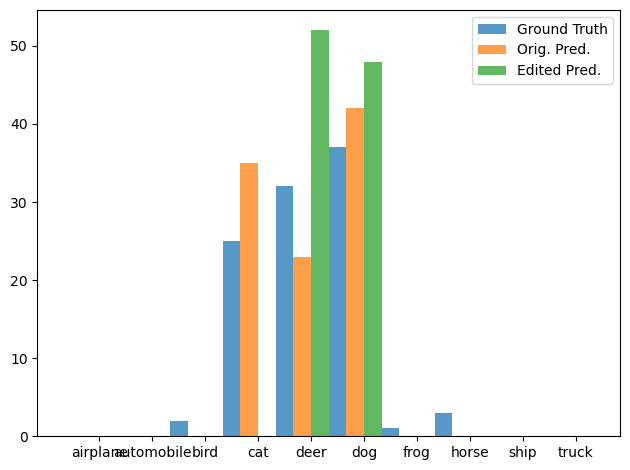

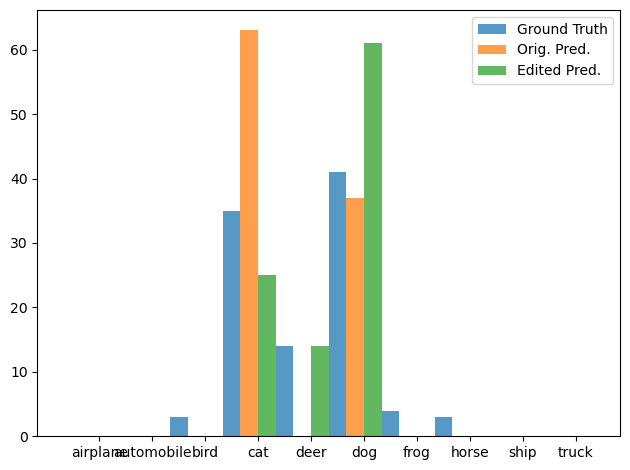

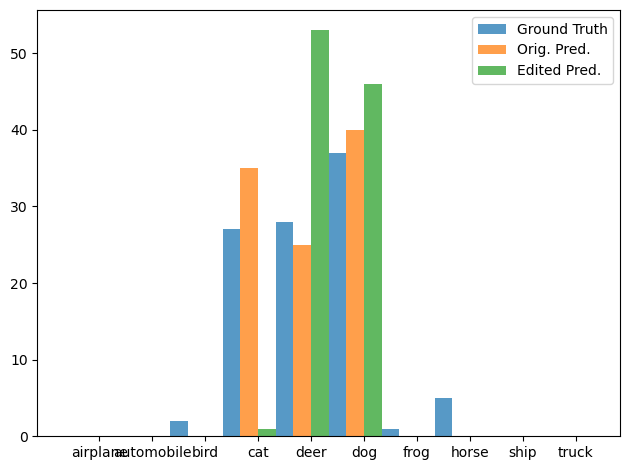

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114367_18628/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114367_18628/felzenszwalb_gaussian_softmax/models
Finished trial 15/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114367_18628/felzenszwalb_gaussian_softmax
(0125_144043) Starting Trial 16/27...
Current run_id: 0125_134842/results/dog-train-n02083346_3775/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02083346_3775/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.78it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0061, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 874.35it/s]

Loss (orig, final): 0.09298978745937347 0.006118021439760923
L2 norm of weight change: 0.3269588351249695
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.64it/s]


Post-edit metrics: {'TP': array([6209, 5676, 5423, 3324, 3955, 3483, 5113, 5397, 4707, 4289]), 'TN': array([59677, 60218, 58419, 61018, 60738, 60930, 62056, 61106, 61733,
       61681]), 'FPs': array([3323, 2782, 4581, 1982, 2262, 2070,  944, 1894, 1267, 1319]), 'FNs': array([ 791, 1324, 1577, 3676, 3045, 3517, 1887, 1603, 2293, 2711]), 'accuracy': 0.6796571428571428, 'per_class_accuracy': array([0.94122857, 0.94134286, 0.91202857, 0.91917143, 0.92418571,
       0.92018571, 0.95955714, 0.95004286, 0.94914286, 0.94242857]), 'per_class_accuracy_mean': 0.9359314285714285, 'precision': array([0.65138481, 0.67108063, 0.54208317, 0.62646061, 0.63615892,
       0.62722853, 0.84414727, 0.74022768, 0.7879143 , 0.76480029]), 'precision_mean': 0.6891486190530521, 'recall': array([0.887     , 0.81085714, 0.77471429, 0.47485714, 0.565     ,
       0.49757143, 0.73042857, 0.771     , 0.67242857, 0.61271429]), 'recall_mean': 0.6796571428571428, 'predicted_class_distribution': array([ 9532,  8458, 100

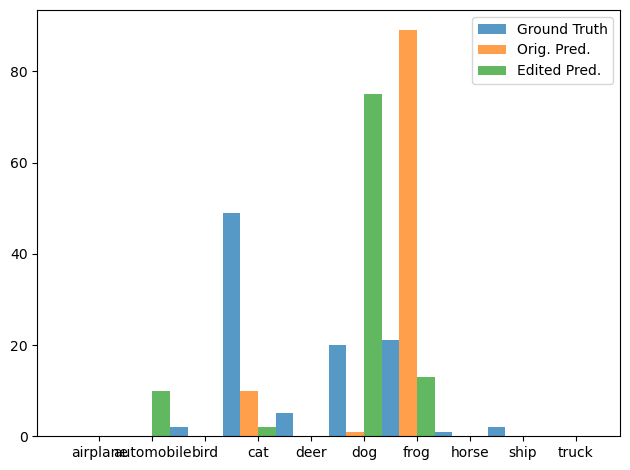

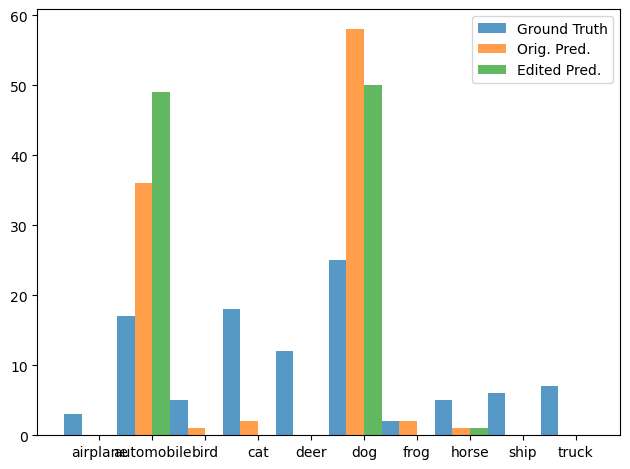

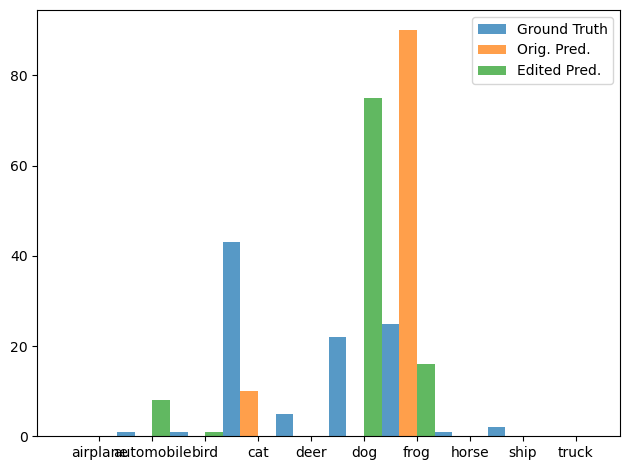

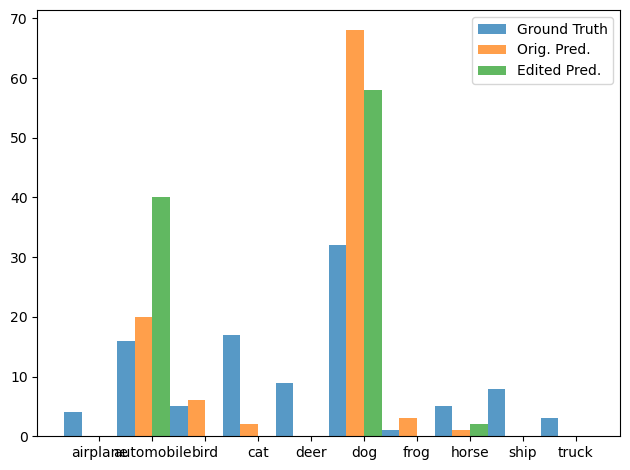

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02083346_3775/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02083346_3775/felzenszwalb_masked_softmax/models
Finished trial 16/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02083346_3775/felzenszwalb_masked_softmax
(0125_144159) Starting Trial 17/27...
Current run_id: 0125_134842/results/dog-train-n01322508_12502/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n01322508_12502/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-ima

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.22it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0073, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 876.30it/s]

Loss (orig, final): 0.13337063789367676 0.007250544149428606
L2 norm of weight change: 0.5035377740859985
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 31.99it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([6052, 5596, 5449, 3835,    0, 4376, 5363, 5031, 4575, 4425]), 'TN': array([60529, 60660, 58513, 59773, 63000, 55065, 61705, 61949, 61909,
       61599]), 'FPs': array([2471, 2340, 4487, 3227,    0, 7935, 1295, 1051, 1091, 1401]), 'FNs': array([ 948, 1404, 1551, 3165, 7000, 2624, 1637, 1969, 2425, 2575]), 'accuracy': 0.6386, 'per_class_accuracy': array([0.95115714, 0.94651429, 0.91374286, 0.90868571, 0.9       ,
       0.84915714, 0.95811429, 0.95685714, 0.94977143, 0.9432    ]), 'per_class_accuracy_mean': 0.9277200000000001, 'precision': array([0.71007861, 0.70514113, 0.54840982, 0.5430473 , 0.        ,
       0.35545447, 0.80549715, 0.827195  , 0.80744794, 0.75952626]), 'precision_mean': 0.6061797674282438, 'recall': array([0.86457143, 0.79942857, 0.77842857, 0.54785714, 0.        ,
       0.62514286, 0.76614286, 0.71871429, 0.65357143, 0.63214286]), 'recall_mean': 0.6386000000000001, 'predicted_class_distribution': array([ 8523,  7936,  9936,  7062,  

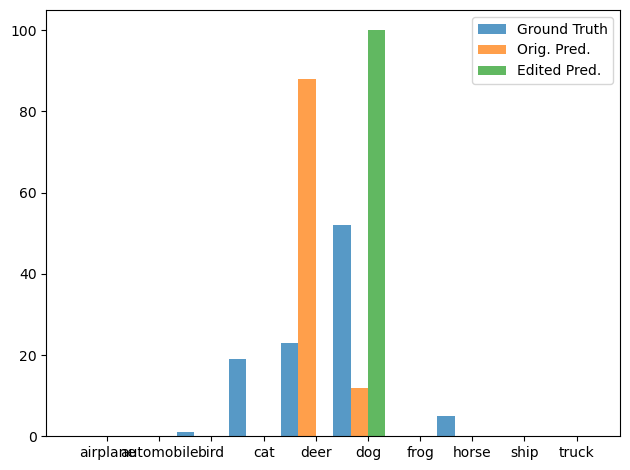

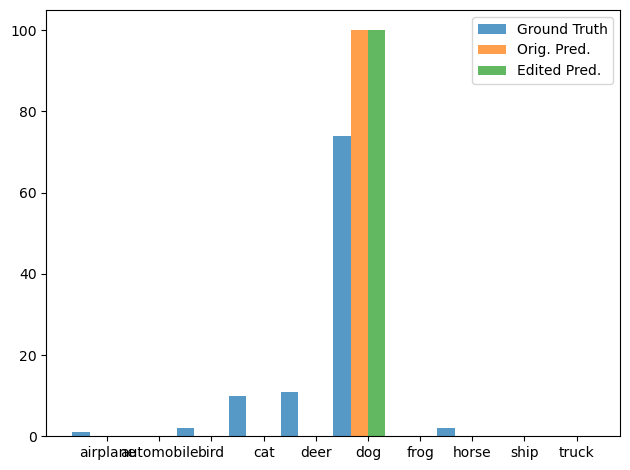

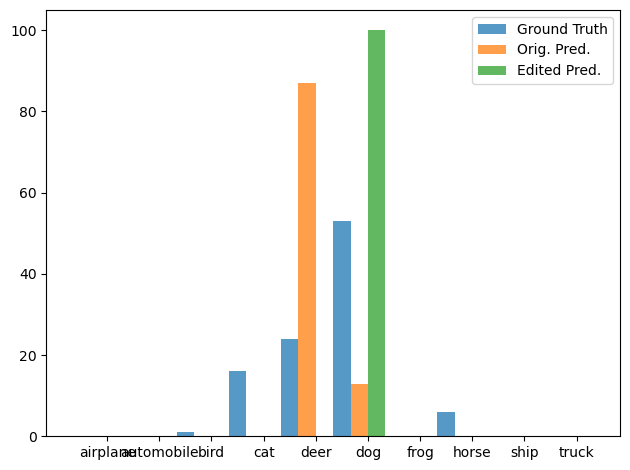

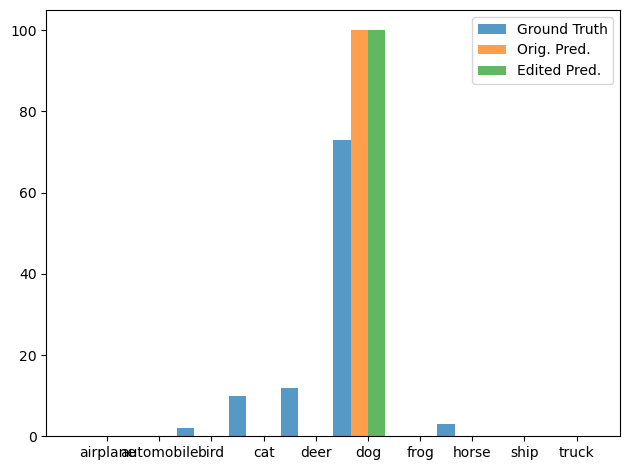

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n01322508_12502/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n01322508_12502/felzenszwalb_masked_softmax/models
Finished trial 17/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n01322508_12502/felzenszwalb_masked_softmax
(0125_144312) Starting Trial 18/27...
Current run_id: 0125_134842/results/dog-train-n01322508_12502/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n01322508_12502/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 37.52it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 887.57it/s]

Loss (orig, final): 0.044441431760787964 0.003954179584980011
L2 norm of weight change: 0.16180311143398285
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.39it/s]


Post-edit metrics: {'TP': array([6110, 5452, 5235, 3937, 3933, 3260, 5654, 5149, 4836, 4628]), 'TN': array([60258, 60988, 59342, 59624, 60884, 61327, 61092, 61775, 61623,
       61281]), 'FPs': array([2742, 2012, 3658, 3376, 2116, 1673, 1908, 1225, 1377, 1719]), 'FNs': array([ 890, 1548, 1765, 3063, 3067, 3740, 1346, 1851, 2164, 2372]), 'accuracy': 0.6884857142857143, 'per_class_accuracy': array([0.94811429, 0.94914286, 0.92252857, 0.90801429, 0.92595714,
       0.92267143, 0.95351429, 0.95605714, 0.94941429, 0.94155714]), 'per_class_accuracy_mean': 0.9376971428571428, 'precision': array([0.69023949, 0.73043944, 0.58866524, 0.53835635, 0.65019011,
       0.66085546, 0.7476858 , 0.80781299, 0.77836794, 0.72916338]), 'precision_mean': 0.6921776218012285, 'recall': array([0.87285714, 0.77885714, 0.74785714, 0.56242857, 0.56185714,
       0.46571429, 0.80771429, 0.73557143, 0.69085714, 0.66114286]), 'recall_mean': 0.6884857142857143, 'predicted_class_distribution': array([8852, 7464, 8893,

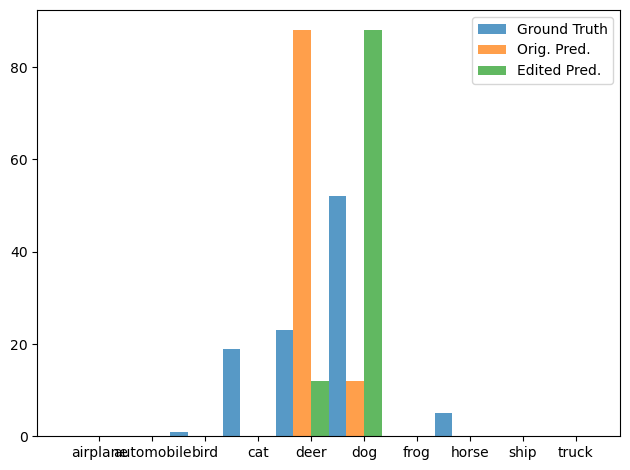

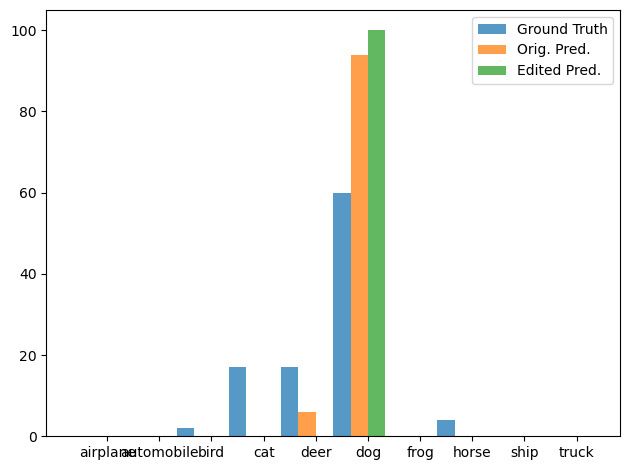

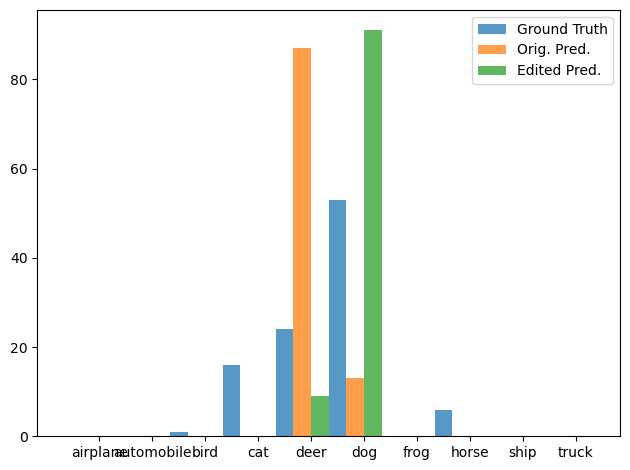

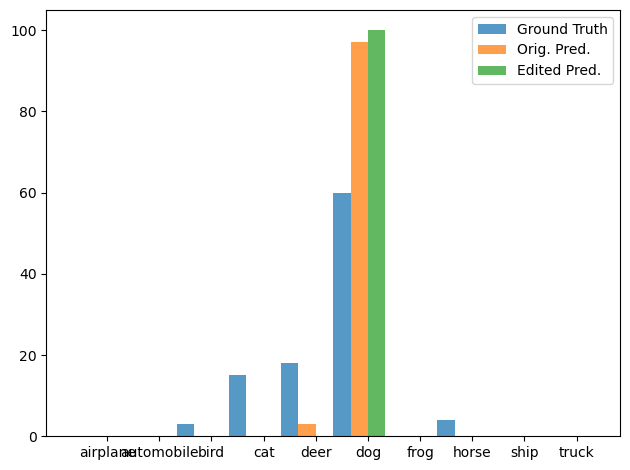

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n01322508_12502/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n01322508_12502/felzenszwalb_gaussian_softmax/models
Finished trial 18/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n01322508_12502/felzenszwalb_gaussian_softmax
(0125_144424) Starting Trial 19/27...
Current run_id: 0125_134842/results/dog-train-n02108089_931/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02108089_931/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-1

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:14<00:00, 18.85it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 878.22it/s]

Loss (orig, final): 0.10467597097158432 0.0050896224565804005
L2 norm of weight change: 0.34691333770751953
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:18<00:00, 14.45it/s]


Post-edit metrics: {'TP': array([5984, 5645, 5059, 3760, 3880, 4064, 5724,  961, 5116, 4270]), 'TN': array([60775, 60562, 59997, 59919, 61011, 55469, 60910, 62952, 61118,
       61750]), 'FPs': array([2225, 2438, 3003, 3081, 1989, 7531, 2090,   48, 1882, 1250]), 'FNs': array([1016, 1355, 1941, 3240, 3120, 2936, 1276, 6039, 1884, 2730]), 'accuracy': 0.6351857142857142, 'per_class_accuracy': array([0.9537    , 0.94581429, 0.92937143, 0.9097    , 0.92701429,
       0.85047143, 0.95191429, 0.91304286, 0.9462    , 0.94314286]), 'per_class_accuracy_mean': 0.927037142857143, 'precision': array([0.72895602, 0.69837931, 0.62751178, 0.54962725, 0.6611007 ,
       0.3504959 , 0.73253135, 0.95242815, 0.73106602, 0.77355072]), 'precision_mean': 0.6805647215794652, 'recall': array([0.85485714, 0.80642857, 0.72271429, 0.53714286, 0.55428571,
       0.58057143, 0.81771429, 0.13728571, 0.73085714, 0.61      ]), 'recall_mean': 0.6351857142857142, 'predicted_class_distribution': array([ 8209,  8083,  806

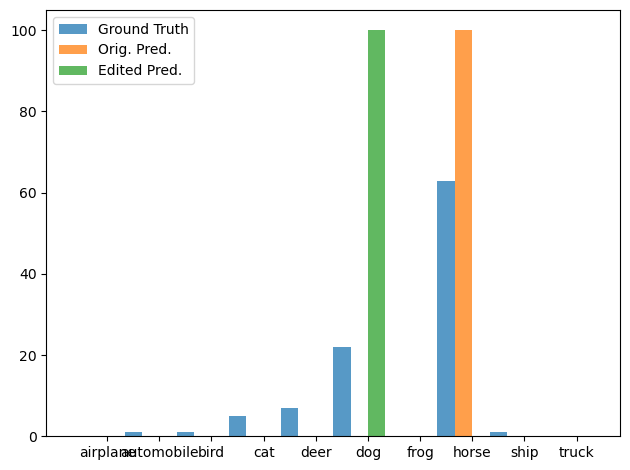

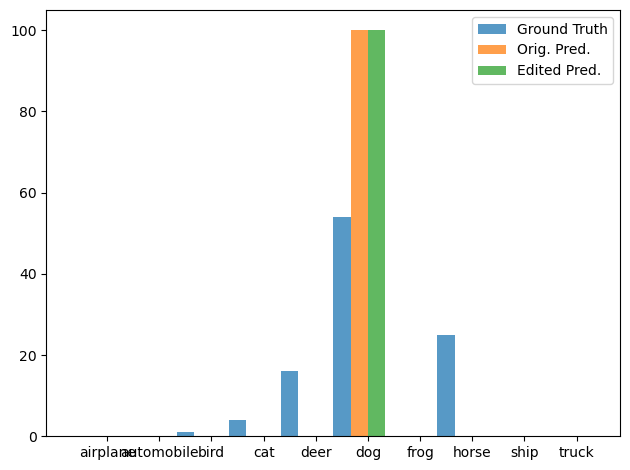

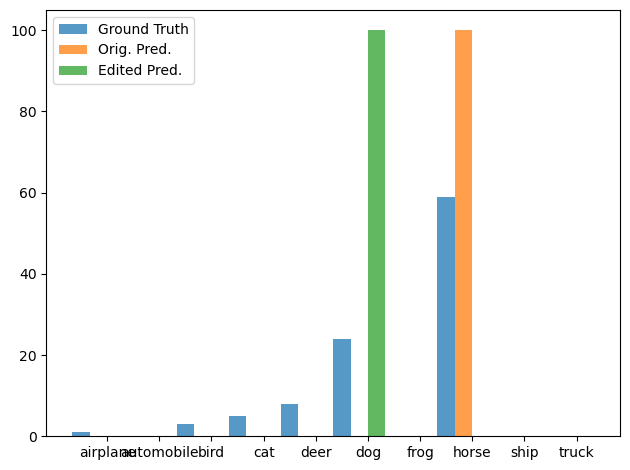

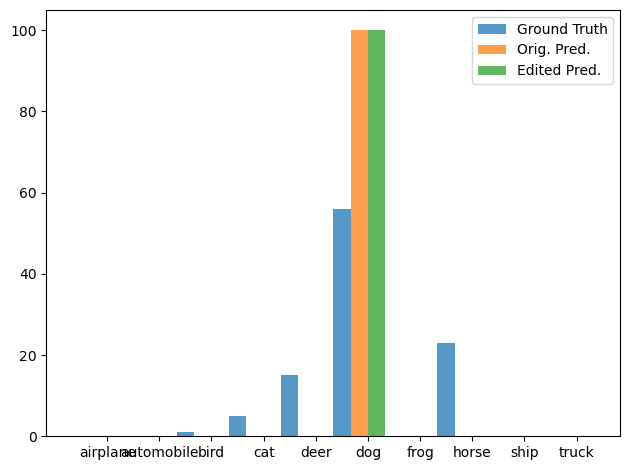

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02108089_931/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02108089_931/felzenszwalb_masked_softmax/models
Finished trial 19/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02108089_931/felzenszwalb_masked_softmax
(0125_144550) Starting Trial 20/27...
Current run_id: 0125_134842/results/dog-train-n02119789_2524/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02119789_2524/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-imag

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.13it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0066, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 882.39it/s]

Loss (orig, final): 0.06176011264324188 0.006612545344978571
L2 norm of weight change: 0.2265421748161316
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:13<00:00, 20.23it/s]


Post-edit metrics: {'TP': array([6126, 5326, 5411, 4198, 3850, 3141, 5294, 5164, 4803, 4655]), 'TN': array([60137, 61234, 58610, 58982, 60994, 61492, 61760, 61741, 61663,
       61355]), 'FPs': array([2863, 1766, 4390, 4018, 2006, 1508, 1240, 1259, 1337, 1645]), 'FNs': array([ 874, 1674, 1589, 2802, 3150, 3859, 1706, 1836, 2197, 2345]), 'accuracy': 0.6852571428571429, 'per_class_accuracy': array([0.94661429, 0.95085714, 0.91458571, 0.90257143, 0.92634286,
       0.92332857, 0.95791429, 0.95578571, 0.94951429, 0.943     ]), 'per_class_accuracy_mean': 0.9370514285714284, 'precision': array([0.68149961, 0.75098703, 0.55208652, 0.51095424, 0.65744536,
       0.67562917, 0.81022345, 0.80398568, 0.78224756, 0.73888889]), 'precision_mean': 0.6963947487401837, 'recall': array([0.87514286, 0.76085714, 0.773     , 0.59971429, 0.55      ,
       0.44871429, 0.75628571, 0.73771429, 0.68614286, 0.665     ]), 'recall_mean': 0.6852571428571429, 'predicted_class_distribution': array([8989, 7092, 9801,

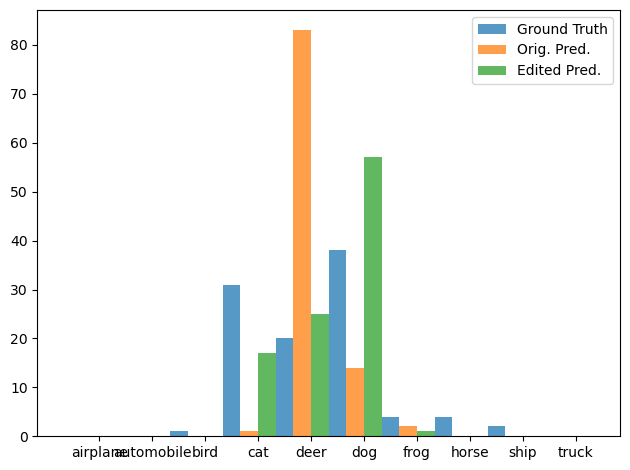

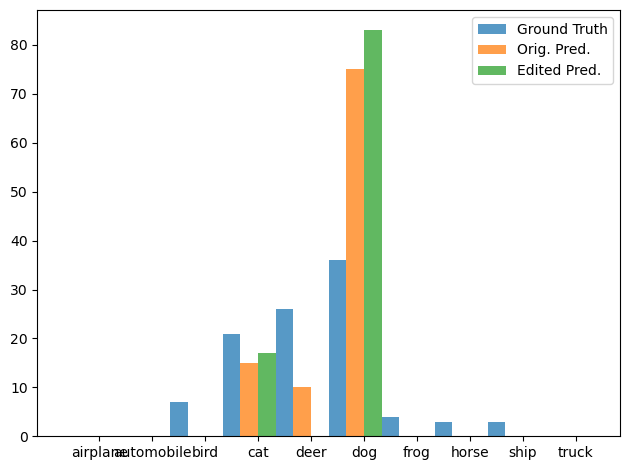

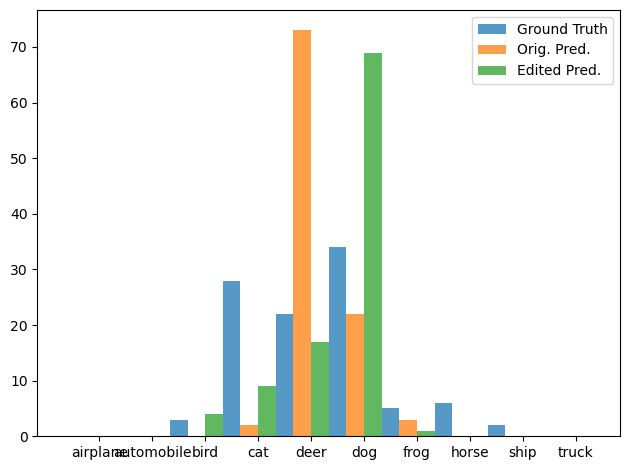

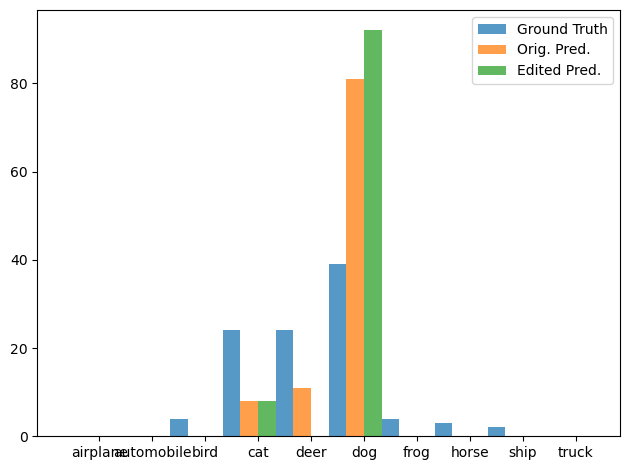

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02119789_2524/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02119789_2524/felzenszwalb_gaussian_softmax/models
Finished trial 20/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02119789_2524/felzenszwalb_gaussian_softmax
(0125_144708) Starting Trial 21/27...
Current run_id: 0125_134842/results/dog-train-n02110341_2396/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02110341_2396/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:06<00:00, 39.97it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0158, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 887.15it/s]

Loss (orig, final): 0.08439113199710846 0.0157935693860054
L2 norm of weight change: 0.35053688287734985
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:09<00:00, 28.09it/s]


Post-edit metrics: {'TP': array([6005, 5694, 5111, 2855, 4325, 4031, 5561, 5365, 4786, 4233]), 'TN': array([60785, 60425, 59885, 61643, 59910, 59295, 61344, 61187, 61692,
       61800]), 'FPs': array([2215, 2575, 3115, 1357, 3090, 3705, 1656, 1813, 1308, 1200]), 'FNs': array([ 995, 1306, 1889, 4145, 2675, 2969, 1439, 1635, 2214, 2767]), 'accuracy': 0.6852285714285714, 'per_class_accuracy': array([0.95414286, 0.94455714, 0.92851429, 0.9214    , 0.91764286,
       0.90465714, 0.95578571, 0.95074286, 0.94968571, 0.94332857]), 'per_class_accuracy_mean': 0.9370457142857143, 'precision': array([0.73053528, 0.68859596, 0.62132264, 0.67782526, 0.58327714,
       0.52107032, 0.77054178, 0.74742268, 0.78536265, 0.77912755]), 'precision_mean': 0.6905081261236988, 'recall': array([0.85785714, 0.81342857, 0.73014286, 0.40785714, 0.61785714,
       0.57585714, 0.79442857, 0.76642857, 0.68371429, 0.60471429]), 'recall_mean': 0.6852285714285713, 'predicted_class_distribution': array([8220, 8269, 8226,

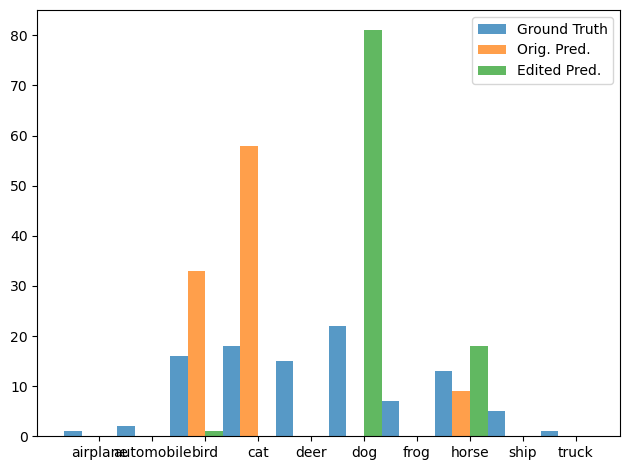

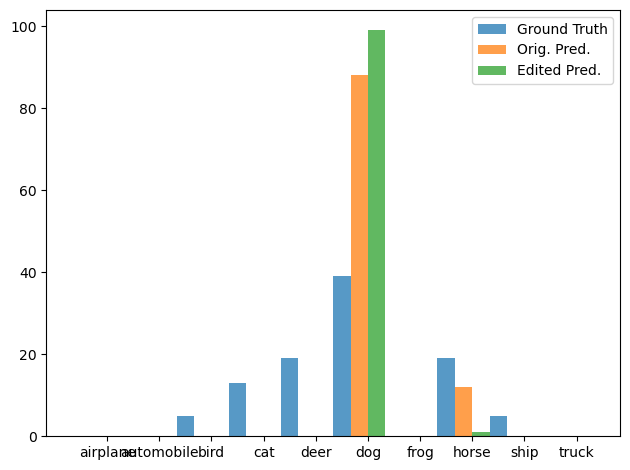

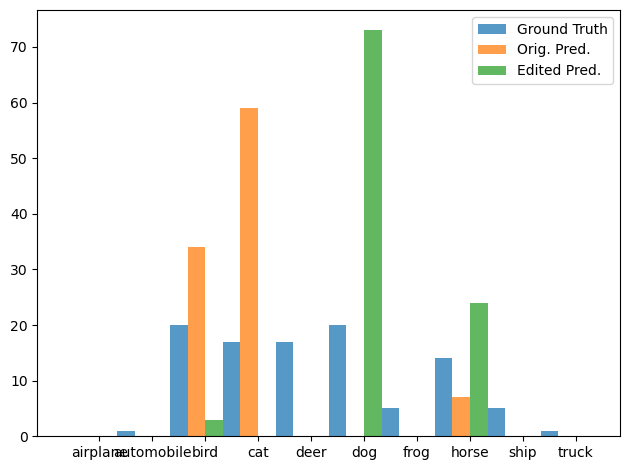

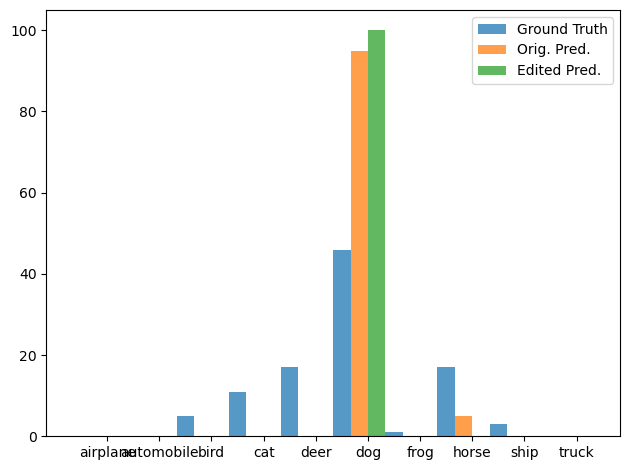

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02110341_2396/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02110341_2396/felzenszwalb_masked_softmax/models
Finished trial 21/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02110341_2396/felzenszwalb_masked_softmax
(0125_144817) Starting Trial 22/27...
Current run_id: 0125_134842/results/dog-train-n02110806_2781/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02110806_2781/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-image

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 35.32it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0074, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 875.51it/s]

Loss (orig, final): 0.0575220100581646 0.007447641342878342
L2 norm of weight change: 0.271517813205719
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.02it/s]


Post-edit metrics: {'TP': array([6055, 5601, 5270, 3536, 3894, 3559, 5683, 5386, 4640, 4538]), 'TN': array([60599, 60622, 59296, 60476, 60952, 60766, 60984, 61207, 61879,
       61381]), 'FPs': array([2401, 2378, 3704, 2524, 2048, 2234, 2016, 1793, 1121, 1619]), 'FNs': array([ 945, 1399, 1730, 3464, 3106, 3441, 1317, 1614, 2360, 2462]), 'accuracy': 0.6880285714285714, 'per_class_accuracy': array([0.9522    , 0.94604286, 0.92237143, 0.91445714, 0.92637143,
       0.91892857, 0.95238571, 0.95132857, 0.95027143, 0.9417    ]), 'per_class_accuracy_mean': 0.9376057142857143, 'precision': array([0.7160596 , 0.70196767, 0.58725206, 0.58349835, 0.6553349 ,
       0.61436216, 0.73814781, 0.75024377, 0.80541573, 0.73704726]), 'precision_mean': 0.6889329312077069, 'recall': array([0.865     , 0.80014286, 0.75285714, 0.50514286, 0.55628571,
       0.50842857, 0.81185714, 0.76942857, 0.66285714, 0.64828571]), 'recall_mean': 0.6880285714285714, 'predicted_class_distribution': array([8456, 7979, 8974,

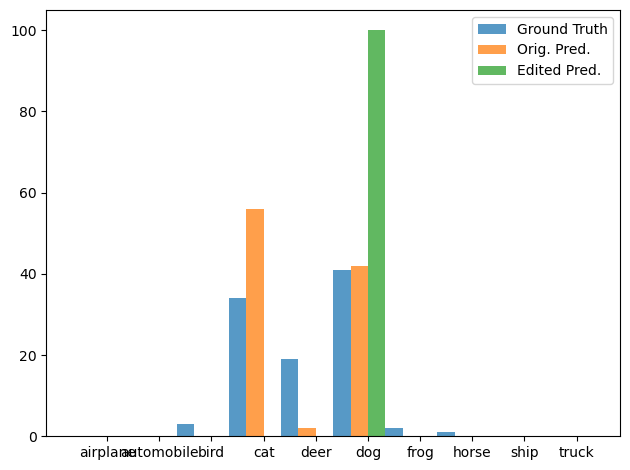

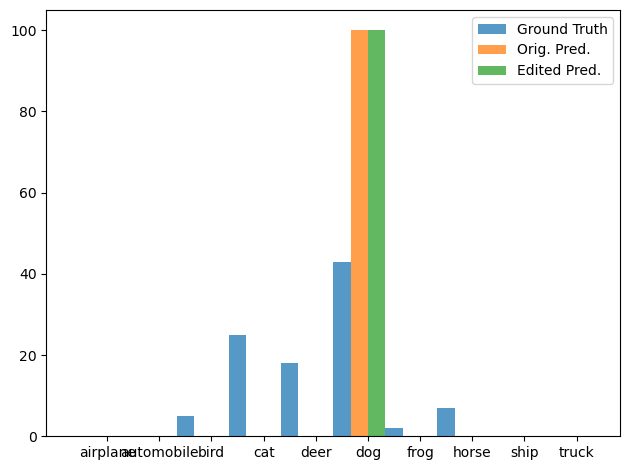

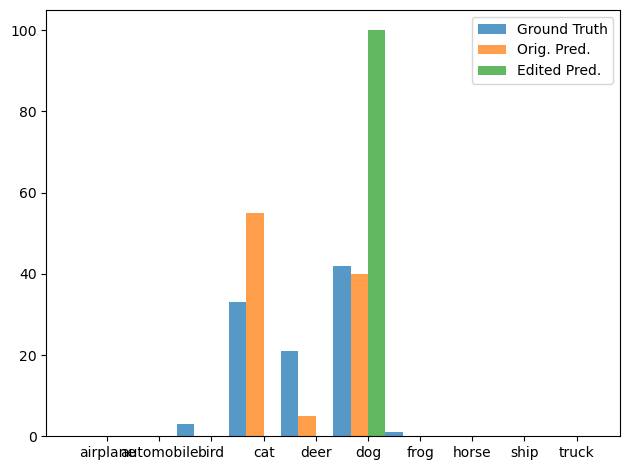

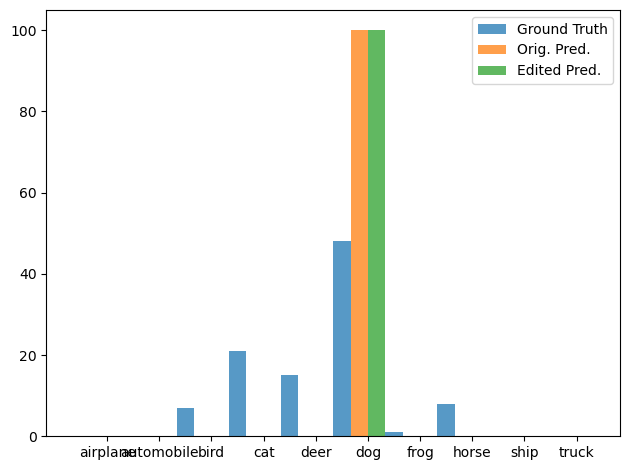

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02110806_2781/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02110806_2781/felzenszwalb_masked_softmax/models
Finished trial 22/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02110806_2781/felzenszwalb_masked_softmax
(0125_144929) Starting Trial 23/27...
Current run_id: 0125_134842/results/dog-train-n01322508_4536/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n01322508_4536/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-image

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 30.91it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0036, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 874.93it/s]

Loss (orig, final): 0.15111878514289856 0.0036115767434239388
L2 norm of weight change: 0.796954333782196
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:07<00:00, 34.43it/s]
/n/fs/ac-editing/model-editing/src/model/metric.py:168: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(TPs / (TPs + FPs))
/n/fs/ac-editing/model-editing/src/model/metric.py:205: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num(2 * precisions * recalls / (precisions + recalls))


Post-edit metrics: {'TP': array([5544, 5063, 3541,    1, 2916, 6446, 5053,    0, 4778,    0]), 'TN': array([61939, 61413, 62409, 62999, 62259, 32559, 62250, 63000, 61514,
       63000]), 'FPs': array([ 1061,  1587,   591,     1,   741, 30441,   750,     0,  1486,
           0]), 'FNs': array([1456, 1937, 3459, 6999, 4084,  554, 1947, 7000, 2222, 7000]), 'accuracy': 0.4763142857142857, 'per_class_accuracy': array([0.96404286, 0.94965714, 0.94214286, 0.9       , 0.93107143,
       0.55721429, 0.96147143, 0.9       , 0.94702857, 0.9       ]), 'per_class_accuracy_mean': 0.8952628571428571, 'precision': array([0.83936412, 0.76135338, 0.85696999, 0.5       , 0.7973749 ,
       0.17474991, 0.87075651, 0.        , 0.76277139, 0.        ]), 'precision_mean': 0.5563340198558109, 'recall': array([7.92000000e-01, 7.23285714e-01, 5.05857143e-01, 1.42857143e-04,
       4.16571429e-01, 9.20857143e-01, 7.21857143e-01, 0.00000000e+00,
       6.82571429e-01, 0.00000000e+00]), 'recall_mean': 0.4763142857

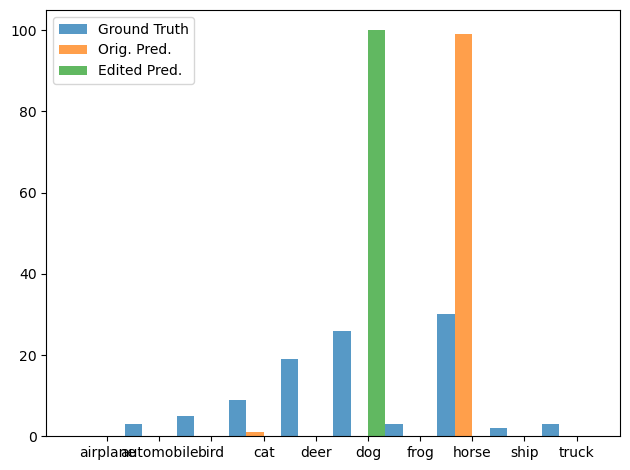

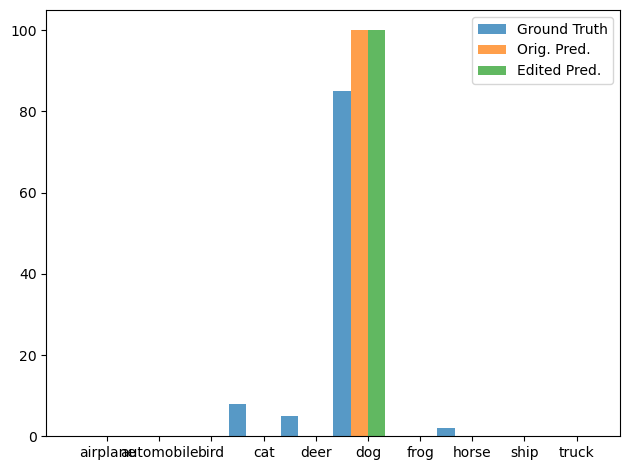

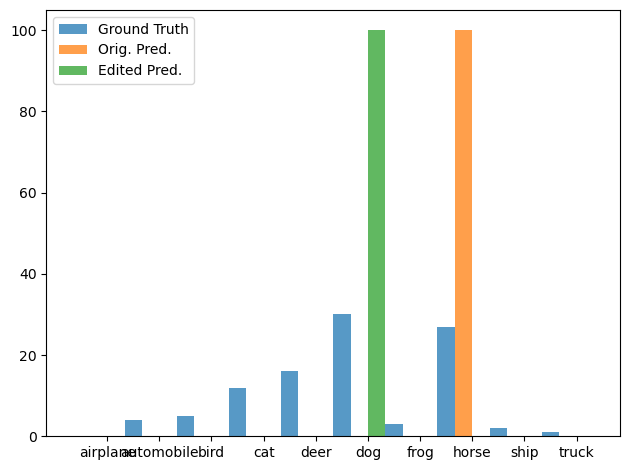

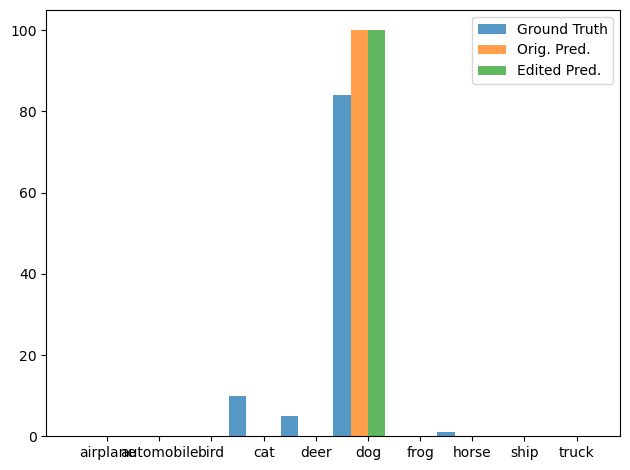

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n01322508_4536/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n01322508_4536/felzenszwalb_masked_softmax/models
Finished trial 23/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n01322508_4536/felzenszwalb_masked_softmax
(0125_145037) Starting Trial 24/27...
Current run_id: 0125_134842/results/dog-train-n02108089_2250/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02108089_2250/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-image

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.39it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0038, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 882.36it/s]

Loss (orig, final): 0.04427662864327431 0.0038337502628564835
L2 norm of weight change: 0.31307846307754517
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.10it/s]


Post-edit metrics: {'TP': array([6198, 5728, 5383, 3478, 4078, 3463, 5437, 5283, 4590, 4138]), 'TN': array([59854, 60377, 58746, 60673, 60490, 60952, 61527, 61437, 61853,
       61867]), 'FPs': array([3146, 2623, 4254, 2327, 2510, 2048, 1473, 1563, 1147, 1133]), 'FNs': array([ 802, 1272, 1617, 3522, 2922, 3537, 1563, 1717, 2410, 2862]), 'accuracy': 0.6825142857142857, 'per_class_accuracy': array([0.9436    , 0.94435714, 0.91612857, 0.91644286, 0.9224    ,
       0.92021429, 0.95662857, 0.95314286, 0.94918571, 0.94292857]), 'per_class_accuracy_mean': 0.9365028571428573, 'precision': array([0.66331336, 0.68590588, 0.55857632, 0.59913867, 0.61900425,
       0.6283796 , 0.78683068, 0.7716915 , 0.80006972, 0.78505028]), 'precision_mean': 0.6897960261068822, 'recall': array([0.88542857, 0.81828571, 0.769     , 0.49685714, 0.58257143,
       0.49471429, 0.77671429, 0.75471429, 0.65571429, 0.59114286]), 'recall_mean': 0.6825142857142857, 'predicted_class_distribution': array([9344, 8351, 9637,

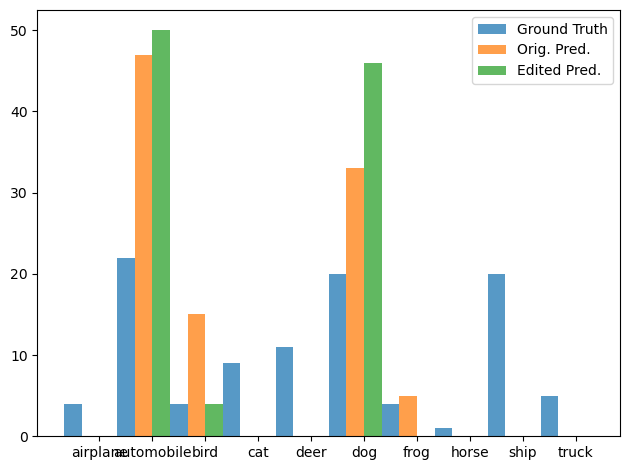

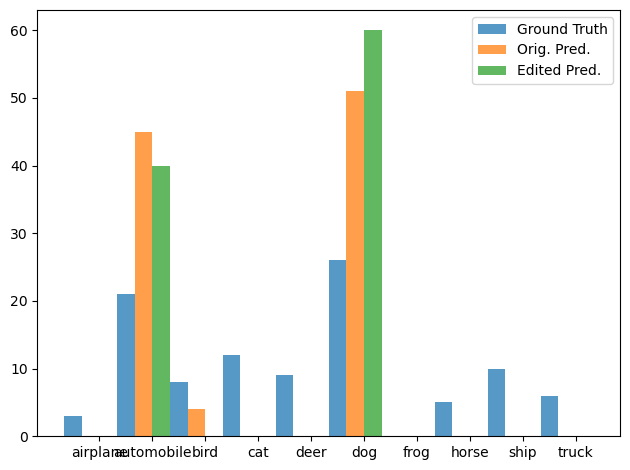

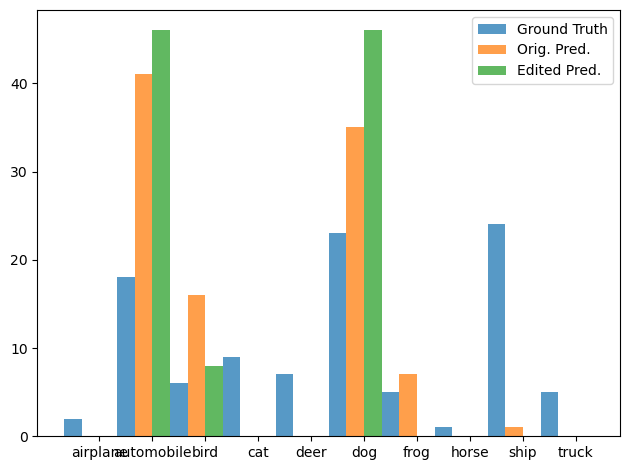

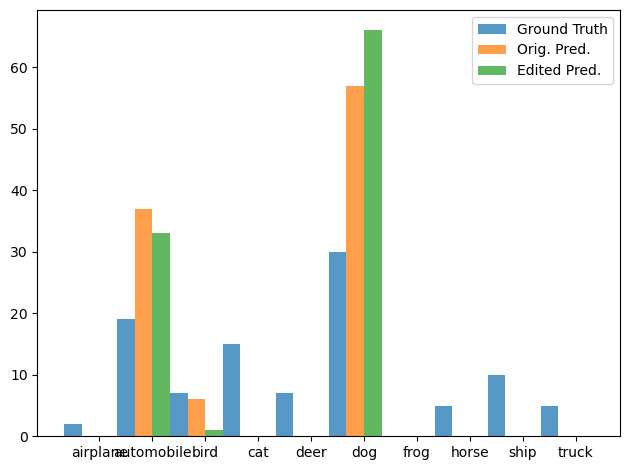

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02108089_2250/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02108089_2250/felzenszwalb_masked_softmax/models
Finished trial 24/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02108089_2250/felzenszwalb_masked_softmax
(0125_145143) Starting Trial 25/27...
Current run_id: 0125_134842/results/dog-train-n02108089_2250/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02108089_2250/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10-i

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 49.50it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0051, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 878.51it/s]

Loss (orig, final): 0.06071225553750992 0.005055312067270279
L2 norm of weight change: 0.37373605370521545
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.63it/s]


Post-edit metrics: {'TP': array([5947, 5234, 5242, 3937, 4361, 3094, 5815, 4892, 4594, 4455]), 'TN': array([60911, 61321, 59117, 59053, 59928, 61352, 60219, 62118, 61866,
       61686]), 'FPs': array([2089, 1679, 3883, 3947, 3072, 1648, 2781,  882, 1134, 1314]), 'FNs': array([1053, 1766, 1758, 3063, 2639, 3906, 1185, 2108, 2406, 2545]), 'accuracy': 0.6795857142857142, 'per_class_accuracy': array([0.95511429, 0.95078571, 0.91941429, 0.89985714, 0.91841429,
       0.92065714, 0.94334286, 0.95728571, 0.94942857, 0.94487143]), 'per_class_accuracy_mean': 0.9359171428571429, 'precision': array([0.7400448 , 0.75712426, 0.57446575, 0.4993658 , 0.58670792,
       0.65246731, 0.67647743, 0.84724628, 0.80202514, 0.77223089]), 'precision_mean': 0.6908155588802629, 'recall': array([0.84957143, 0.74771429, 0.74885714, 0.56242857, 0.623     ,
       0.442     , 0.83071429, 0.69885714, 0.65628571, 0.63642857]), 'recall_mean': 0.6795857142857142, 'predicted_class_distribution': array([8036, 6913, 9125,

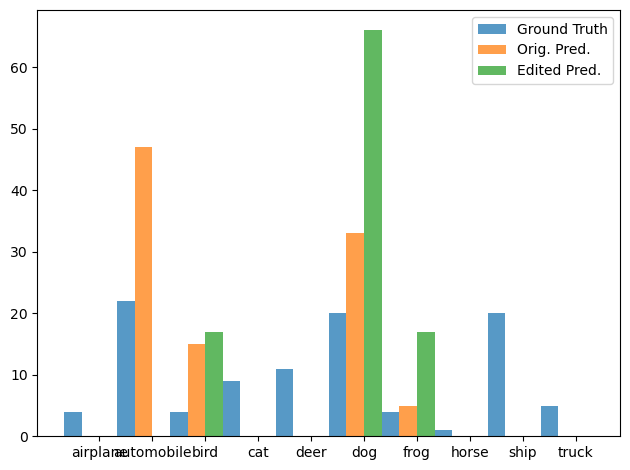

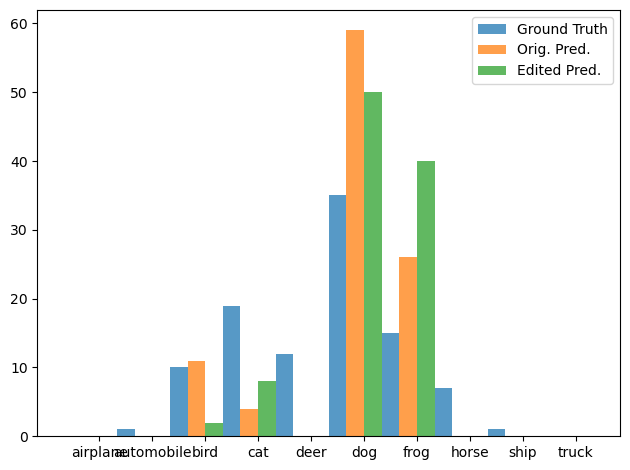

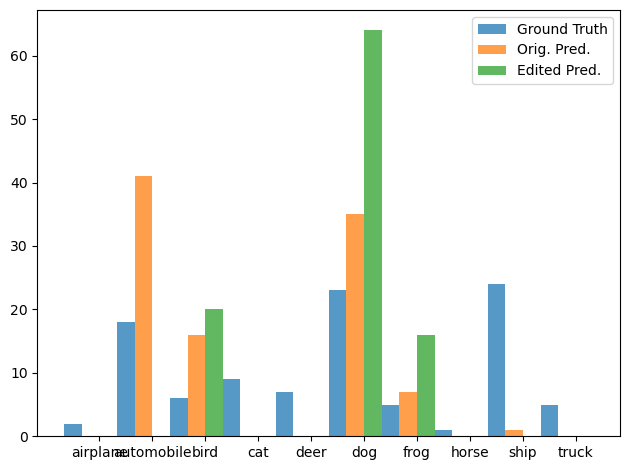

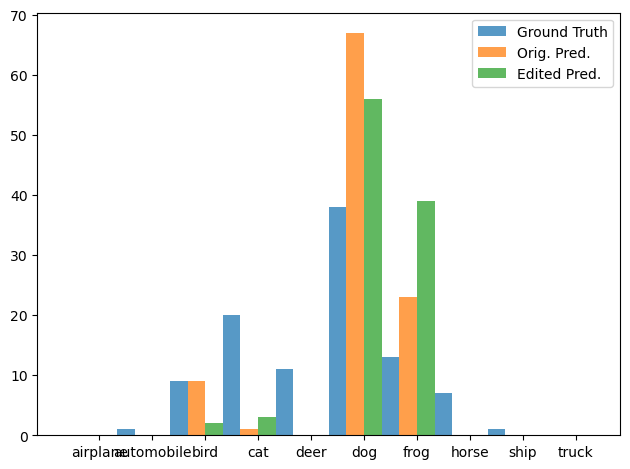

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02108089_2250/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02108089_2250/felzenszwalb_gaussian_softmax/models
Finished trial 25/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02108089_2250/felzenszwalb_gaussian_softmax
(0125_145248) Starting Trial 26/27...
Current run_id: 0125_134842/results/dog-train-n02114548_3866/felzenszwalb_masked_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114548_3866/felzenszwalb_masked_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 53.68it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0429, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 871.06it/s]

Loss (orig, final): 0.16225484013557434 0.042904023081064224
L2 norm of weight change: 0.4726504981517792
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:08<00:00, 33.90it/s]


Post-edit metrics: {'TP': array([5996, 5751, 5278,   23, 4301, 4720, 5526, 5013, 4887, 3970]), 'TN': array([60748, 60391, 59204, 62968, 60005, 55205, 61389, 61959, 61499,
       62097]), 'FPs': array([2252, 2609, 3796,   32, 2995, 7795, 1611, 1041, 1501,  903]), 'FNs': array([1004, 1249, 1722, 6977, 2699, 2280, 1474, 1987, 2113, 3030]), 'accuracy': 0.6495, 'per_class_accuracy': array([0.95348571, 0.94488571, 0.92117143, 0.89987143, 0.91865714,
       0.85607143, 0.95592857, 0.95674286, 0.94837143, 0.94381429]), 'per_class_accuracy_mean': 0.9299, 'precision': array([0.72696411, 0.68791866, 0.58166189, 0.41818182, 0.5895011 ,
       0.37714742, 0.77427491, 0.82804757, 0.76502818, 0.81469321]), 'precision_mean': 0.6563418864260956, 'recall': array([0.85657143, 0.82157143, 0.754     , 0.00328571, 0.61442857,
       0.67428571, 0.78942857, 0.71614286, 0.69814286, 0.56714286]), 'recall_mean': 0.6495, 'predicted_class_distribution': array([ 8248,  8360,  9074,    55,  7296, 12515,  7137,  605

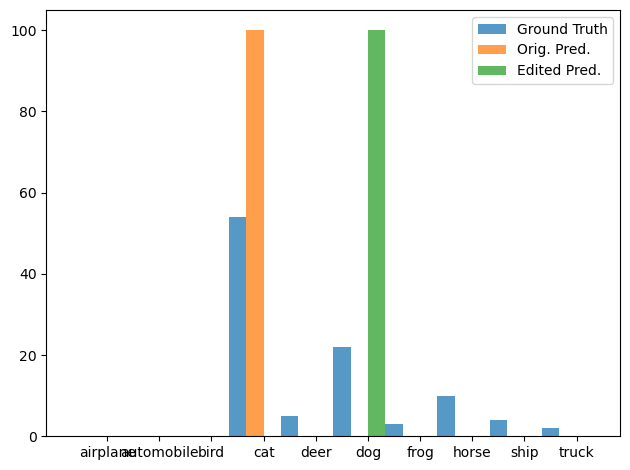

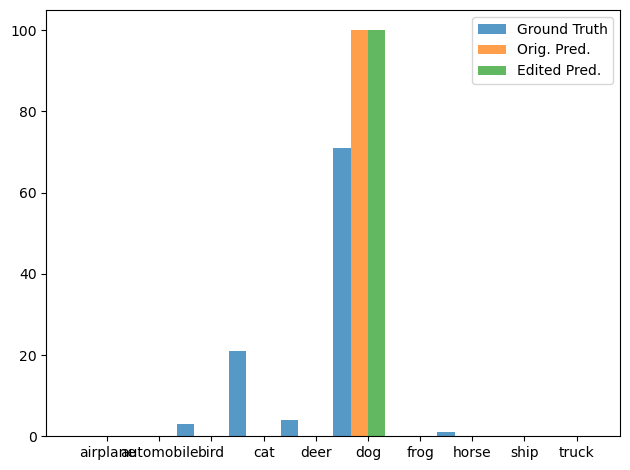

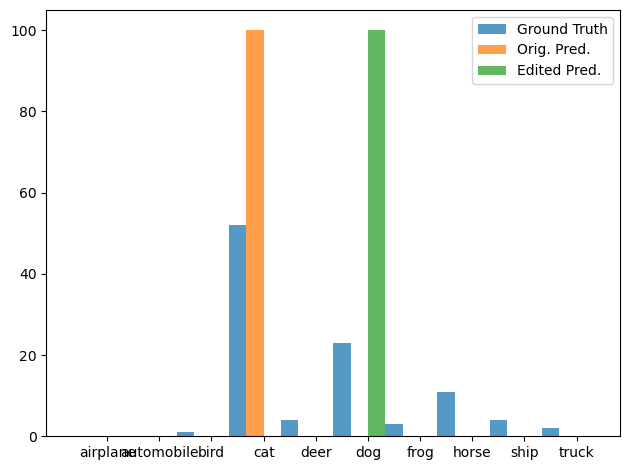

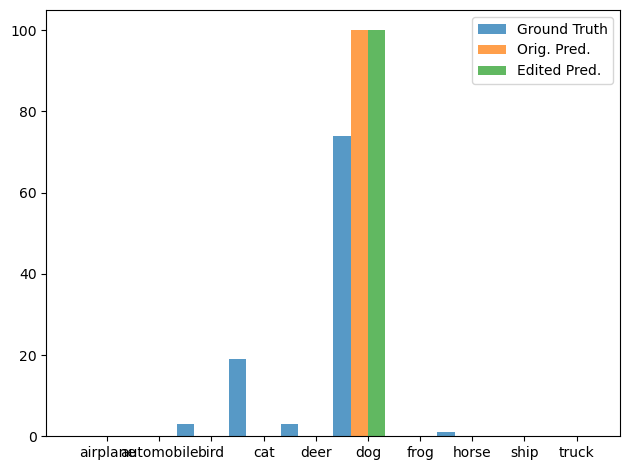

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114548_3866/felzenszwalb_masked_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114548_3866/felzenszwalb_masked_softmax/models
Finished trial 26/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02114548_3866/felzenszwalb_masked_softmax
(0125_145353) Starting Trial 27/27...
Current run_id: 0125_134842/results/dog-train-n02113186_13534/felzenszwalb_gaussian_softmax
saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02113186_13534/felzenszwalb_gaussian_softmax
Calling edit()...
Created CIFAR10PretrainedModelEdit model with 33646666 trainable parameters
Restored weights from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt
Using passed in data loader for validation.
Key images: data/cinic-10

100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:05<00:00, 47.06it/s]


Pre-edit metrics: {'TP': array([6142, 5382, 5202, 3841, 4270, 2990, 5659, 5135, 4819, 4679]), 'TN': array([60112, 61110, 59444, 59899, 60157, 61754, 61051, 61747, 61643,
       61202]), 'FPs': array([2888, 1890, 3556, 3101, 2843, 1246, 1949, 1253, 1357, 1798]), 'FNs': array([ 858, 1618, 1798, 3159, 2730, 4010, 1341, 1865, 2181, 2321]), 'accuracy': 0.6874142857142858, 'per_class_accuracy': array([0.94648571, 0.94988571, 0.92351429, 0.91057143, 0.92038571,
       0.92491429, 0.953     , 0.95545714, 0.94945714, 0.94115714]), 'per_class_accuracy_mean': 0.9374828571428573, 'precision': array([0.68017719, 0.74009901, 0.59397123, 0.55329876, 0.60030929,
       0.70585458, 0.74382229, 0.80385097, 0.7802785 , 0.72240235]), 'precision_mean': 0.6924064164231064, 'recall': array([0.87742857, 0.76885714, 0.74314286, 0.54871429, 0.61      ,
       0.42714286, 0.80842857, 0.73357143, 0.68842857, 0.66842857]), 'recall_mean': 0.6874142857142858, 'predicted_class_distribution': array([9030, 7272, 8758, 

tensor(0.0045, device='cuda:0', grad_fn=<DivBackward0>): 100%|███████| 40000/40000 [00:45<00:00, 879.50it/s]

Loss (orig, final): 0.06710858643054962 0.004502063151448965
L2 norm of weight change: 0.1982840746641159
Performing post-edit metric & KNN calculations on validation set.



100%|█████████████████████████████████████████████████████████████████████| 274/274 [00:11<00:00, 23.89it/s]


Post-edit metrics: {'TP': array([6076, 5458, 5226, 3824, 4232, 3326, 5691, 4568, 5055, 4451]), 'TN': array([60314, 60994, 59329, 59800, 60255, 61032, 60963, 62416, 61231,
       61573]), 'FPs': array([2686, 2006, 3671, 3200, 2745, 1968, 2037,  584, 1769, 1427]), 'FNs': array([ 924, 1542, 1774, 3176, 2768, 3674, 1309, 2432, 1945, 2549]), 'accuracy': 0.6843857142857143, 'per_class_accuracy': array([0.94842857, 0.94931429, 0.92221429, 0.90891429, 0.92124286,
       0.9194    , 0.9522    , 0.95691429, 0.94694286, 0.9432    ]), 'per_class_accuracy_mean': 0.9368771428571427, 'precision': array([0.69344898, 0.7312433 , 0.58738901, 0.54441913, 0.60656443,
       0.62825841, 0.73641304, 0.88664596, 0.74076788, 0.75723035]), 'precision_mean': 0.6912380493817439, 'recall': array([0.868     , 0.77971429, 0.74657143, 0.54628571, 0.60457143,
       0.47514286, 0.813     , 0.65257143, 0.72214286, 0.63585714]), 'recall_mean': 0.6843857142857142, 'predicted_class_distribution': array([8762, 7464, 8897,

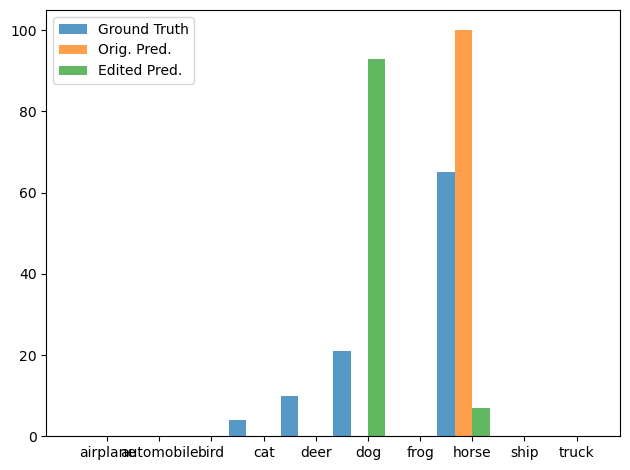

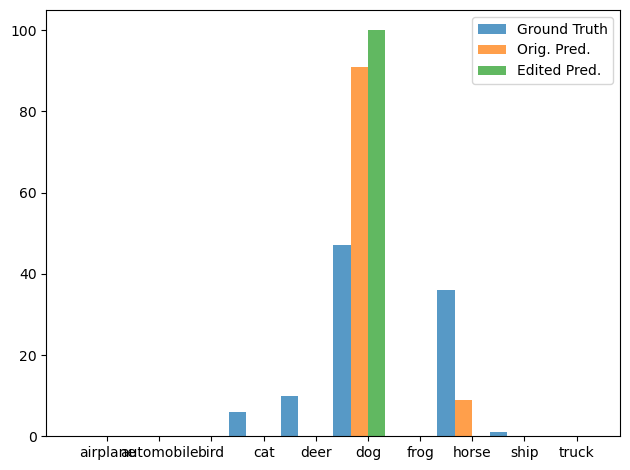

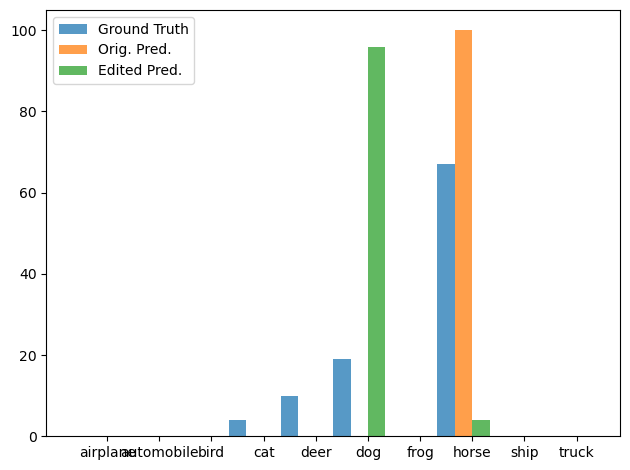

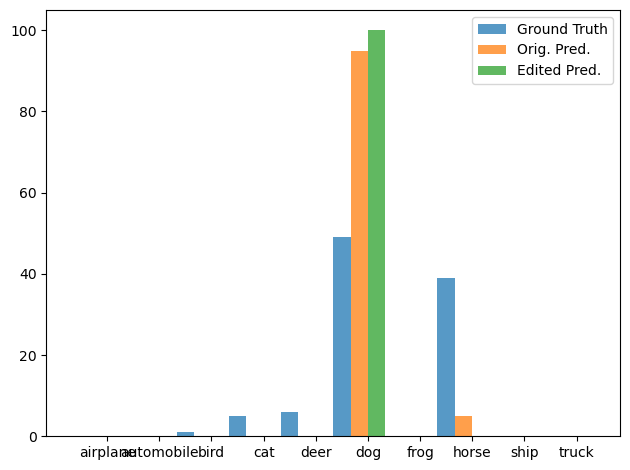

Saved KNN analysis results to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02113186_13534/felzenszwalb_gaussian_softmax/models/knn_analysis_results.pth

All metrics and KNN results can be found in saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02113186_13534/felzenszwalb_gaussian_softmax/models
Finished trial 27/27. Results saved to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_134842/results/dog-train-n02113186_13534/felzenszwalb_gaussian_softmax


In [26]:
for idx, (key_path, value_path) in enumerate(zip(key_image_paths, value_image_paths)):
    split = os.path.basename(os.path.dirname(os.path.dirname(key_path)))
    class_name = os.path.basename(os.path.dirname(key_path))
    file_name = os.path.basename(key_path).split(".")[0]
    key_image_id = "{}-{}-{}".format(class_name, split, file_name)
    # Print Progress
    informal_log("({}) Starting Trial {}/{}...".format(datetime.now().strftime(r'%m%d_%H%M%S'), idx + 1, n_trials), progress_report_path)
    
    # Create run id 
    value_image_id = os.path.splitext(os.path.basename(value_path))[0]
    run_id = os.path.join(timestamp, 'results', key_image_id, value_image_id)
    informal_log("Current run_id: {}".format(run_id), progress_report_path)
    
    # Read config file as json and make updates to key and value paths
    config_dict = read_json(config_path)
    config_dict['editor'].update({
        'key_paths_file': key_path,
        'value_paths_file': value_path
    })
    
    # Create config object
    config = ConfigParser(config_dict, run_id=run_id)
    
    # Log the current trial path
    informal_log(os.path.dirname(config.save_dir), save_trials_path)
    
    informal_log("Calling edit()...", progress_report_path)
    
    edit(
        config=config,
        val_paths_data_loader=val_paths_data_loader,
        covariance_data_loader=covariance_data_loader,
        do_analyze_knn=analyze_in_edit)
    
    # Print progress
    informal_log("Finished trial {}/{}. Results saved to {}".format(idx + 1, n_trials, os.path.dirname(config.save_dir)),
                progress_report_path)


In [5]:
save_trials_path = 'saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/trial_paths.txt'
trial_dirs = read_lists(save_trials_path)
knn_analysis_filename = 'knn_analysis_results.pth'

In [6]:
try:
    if not os.path.exists(save_trials_path):
        print("Path {} does not exist".format(save_trials_path))
    else:
        print("Obtaining trial paths from {}".format(save_trials_path))
except:
    print("Need to define save_trials_path.")



Obtaining trial paths from saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/trial_paths.txt


## Analyze KNN

In [ ]:
## Process KNN results for each
n_trials = len(trial_dirs)
n_log = n_trials // 10 + 1  # log every 10%
progress_report_path = os.path.join(os.path.dirname(save_trials_path), 'progress_report_analysis.txt')

informal_log("Starting KNN analysis...", progress_report_path)
for trial_idx, trial_dir in tqdm(enumerate(trial_dirs)):
    # if trial_idx % n_log == 0:
    informal_log("Processing {}/{} trials. Currently processing {}".format(
        trial_idx+1, n_trials, os.path.basename(trial_dir)), progress_report_path)
                     
    results_save_dir = os.path.join(trial_dir, 'models')
    load_and_analyze_knn(
        restore_dir=results_save_dir,
        pre_edit_knn_path=os.path.join(results_save_dir, 'pre_edit_{}-nn.pth'.format(K)),
        post_edit_knn_path=os.path.join(results_save_dir, 'post_edit_{}-nn.pth'.format(K)),
        knn_analysis_filename=knn_analysis_filename,
        target_class_idx=target_class_idx,
        class_list=class_list,
        progress_report_path=progress_report_path,
        save_images=False,
        save_plots=True)
    


## Convert to CSV for all trials

In [15]:
csv_save_path = os.path.join(os.path.dirname(save_trials_path), 'results_table.csv')
store_csv(
    trial_dirs=trial_dirs,
    class_list=class_list,
    save_path=csv_save_path)


67it [00:00, 213.64it/s]


Saved CSV to saved/edit/trials/CINIC10_ImageNet-VGG_16/0125_114341/results_table.csv


,ID,Pre Accuracy,Post Accuracy,Pre Mean Precision,Post Mean Precision,Pre Mean Recall,Post Mean Recall,Pre Mean F1,Post Mean F1,Pre Target Precision,...,Pre key-valN (L),Post key-valN (L),Pre key-keyN (F),Post key-keyN (F),Pre key-keyN (L),Post key-keyN (L),Pre val-valN (F),Post val-valN (F),Pre val-valN (L),Post val-valN (L)
0,cat-train-n02123159_5240/felzenszwalb_masked_s...,0.687414,0.672186,0.692406,0.709197,0.687414,0.672186,0.683682,0.670420,0.553299,...,5.171321,3.169234,0.596380,0.594950,0.710303,0.703269,0.723165,0.660501,0.856312,0.728696
1,cat-train-n02123159_5240/felzenszwalb_gaussian...,0.687414,0.633886,0.692406,0.598608,0.687414,0.633886,0.683682,0.603072,0.553299,...,8.166020,2.563223,0.596380,0.523944,0.710303,0.591248,1.175095,1.062049,1.603575,1.291547
2,cat-train-n02129837_1765/felzenszwalb_masked_s...,0.687414,0.607971,0.692406,0.646743,0.687414,0.607971,0.683682,0.596876,0.553299,...,6.564913,2.954387,0.935025,0.774271,1.173931,0.908001,0.107244,0.119450,0.094630,0.126227
3,cat-train-n02129923_8962/felzenszwalb_masked_s...,0.687414,0.632857,0.692406,0.623802,0.687414,0.632857,0.683682,0.611744,0.553299,...,5.371199,2.632539,0.763008,0.722909,0.921382,0.824346,0.264432,0.202699,0.265210,0.208668
4,cat-train-n02129923_8962/felzenszwalb_gaussian...,0.687414,0.686829,0.692406,0.694383,0.687414,0.686829,0.683682,0.684031,0.553299,...,1.375438,1.304161,0.763008,0.755527,0.921382,0.890317,0.705127,0.695496,0.855772,0.842393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,cat-train-n02127808_5137/felzenszwalb_masked_s...,0.687414,0.576271,0.692406,0.631007,0.687414,0.576271,0.683682,0.549253,0.553299,...,8.245894,2.834608,0.584197,0.395530,0.732502,0.347604,0.511980,0.483379,0.641546,0.557572
63,cat-train-n02129991_438/felzenszwalb_masked_so...,0.687414,0.673171,0.692406,0.695573,0.687414,0.673171,0.683682,0.665643,0.553299,...,8.212924,3.519887,0.823938,0.616917,1.030968,0.736741,1.368564,1.205212,1.820486,1.502170
64,cat-train-n02126640_2067/felzenszwalb_masked_s...,0.687414,0.450029,0.692406,0.573060,0.687414,0.450029,0.683682,0.453774,0.553299,...,7.195724,5.414852,1.244950,1.043974,1.714823,1.123954,0.188591,0.265671,0.188976,0.322151
65,cat-train-n02129463_8239/felzenszwalb_masked_s...,0.687414,0.635029,0.692406,0.611812,0.687414,0.635029,0.683682,0.608942,0.553299,...,8.692849,4.320444,0.183258,0.187100,0.172564,0.179578,0.789132,0.693472,1.048873,0.840776
